### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
from scipy import stats

import re
import json
from datetime import datetime
from pandas import json_normalize
from sklearn.metrics import roc_auc_score

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

from plotly import subplots
from plotly import version
color = sns.color_palette()

init_notebook_mode(connected=True)
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error as MSE

from xgboost import XGBRegressor
from xgboost import XGBClassifier
#!pip install shap
import shap

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Function declaration

In [2]:
def read_clean_data(csv_path,flg=0):
    #Columns that contain JSON values
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource'] 
    
    #reading the csv file and marking defining JSON columns
    df = pd.read_csv(csv_path, converters = {col: json.loads for col in json_cols}, dtype = {'fullVisitorId': 'str'}) 
    
    #Extracting values from JSON columns and creating seperate columns for them
    for col in json_cols:
        df_extended = json_normalize(df[col])
        df_extended.columns = [f"{col}_{subcol}" for subcol in df_extended.columns]
        df = df.drop(col, axis = 1).merge(df_extended, right_index = True, left_index = True)
        
    #Converting the date to suitable format
    df['date'] = df['date'].apply(make_date)
    df['date'] = pd.to_datetime(df['date'])
    
    #Converting the date time to suitable format
    #df['visitStartTime'] = df['visitStartTime'].apply(lambda ts : datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
    df['visitStartTime_hour'] = df['visitStartTime'].apply(lambda ts : datetime.utcfromtimestamp(ts).strftime('%H'))
    
    
    #Changing the column types
    if flg==0:
        num_lst = ['totals_visits','totals_hits','totals_pageviews','totals_bounces','totals_newVisits','totals_transactionRevenue']
    else:
        num_lst = ['totals_visits','totals_hits','totals_pageviews','totals_bounces','totals_newVisits']
    for col in num_lst:
        df[col] = df[col].astype(float)
    
    df.replace(to_replace='not available in demo dataset',value='NA',inplace=True)
    
    return df

In [3]:
def make_date(x):
    """
    This function returns the date in proper format
    """
    year = x//10000
    month = x%10000//100
    date = x%100
    
    return f"{year}/{month}/{date}"

In [4]:
def handle_na(df_tmp,flg=0):
    
    #Cleaning traffic column
    traff_lst = ['trafficSource_campaign',
       'trafficSource_source',
       'trafficSource_medium',
       'trafficSource_keyword',
       'trafficSource_keyword',
       'trafficSource_adwordsClickInfo.criteriaParameters',
       'trafficSource_isTrueDirect',
       'trafficSource_referralPath']
    lst2=[
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adContent']
    
    for col in traff_lst:
        df_tmp[col].fillna('NA',inplace=True)
    
    df_tmp.drop(lst2,axis=1,inplace=True)
    #This column has only 1 unique value in the sample dataset, so removing it from final prepared data
    if flg==0:
        df_tmp.drop('trafficSource_campaignCode',axis=1,inplace=True)
    
        
    
    return df_tmp

def clean_data(df_tmp,flg=0):
    cols_lst = ['socialEngagementType', 'device_browserVersion', 'device_browserSize',
     'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel',
     'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
     'device_flashVersion', 'device_language', 'device_screenColors',
     'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude',
     'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits',
     'trafficSource_adwordsClickInfo.criteriaParameters']
    
    for x in cols_lst:
        df_tmp.drop(x,axis=1,inplace=True)
    
    if flg == 0: #train data
        cols_lst2 = ['totals_transactionRevenue','totals_newVisits','totals_bounces','totals_hits','totals_pageviews']
    else: #test data
        cols_lst2 = ['totals_newVisits','totals_bounces','totals_hits','totals_pageviews']
    for x in cols_lst2:  # Filling NAs for totals columns
        df_tmp[x].fillna(0,inplace=True)
        
    df_tmp['date'] = pd.to_datetime(df_tmp['date'])
    df_tmp['Date_month'] = df_tmp['date'].apply(lambda x: x.strftime('%Y-%m'))
    df_tmp['Day'] = df_tmp['date'].apply(lambda x: x.strftime('%A'))
    df_tmp['Day_num'] = df_tmp['date'].apply(lambda x: x.weekday())
    
    return df_tmp

### EDA

In [5]:
def pie_channelgroup(df_tmp,flg1=0): #Pie Chart
    if flg1 == 0: #General distribution
        tmp_vc = df_tmp['channelGrouping'].value_counts()
        tc = go.Pie(labels = tmp_vc.index, values = tmp_vc.values)
        lt = go.Layout(title = "Channel Grouping Distribution", height = 450)
        fig = go.Figure(data = [tc], layout = lt)
        iplot(fig)
    else:
        if flg1 ==1: #Mean contribution
            tmp_vc = df_tmp.groupby('channelGrouping').mean()['totals_transactionRevenue'].reset_index()\
                                .rename({'totals_transactionRevenue':'Avg_Revenue'},axis=1)
            tmp_vc = tmp_vc.dropna()
            tc = go.Pie(labels = tmp_vc['channelGrouping'], values = tmp_vc['Avg_Revenue'])
            lt = go.Layout(title = "Channel Grouping Distribution by Avg Rev contribution", height = 450)
        else: #Total contribution
            tmp_vc = df_tmp.groupby('channelGrouping').sum()['totals_transactionRevenue'].reset_index()\
                                .rename({'totals_transactionRevenue':'total_Revenue'},axis=1)
            tmp_vc = tmp_vc.dropna()
            tc = go.Pie(labels = tmp_vc['channelGrouping'], values = tmp_vc['total_Revenue'])
            lt = go.Layout(title = "Channel Grouping Distribution by Total Rev contribution", height = 450)
        
        fig = go.Figure(data = [tc], layout = lt)
        iplot(fig)

In [6]:
def enumerate_graph(df_tmp,flg,lst):
    tc = []
    
    for i,col in enumerate(lst):
        if(flg ==0):
            d_vc = df_tmp[col].value_counts()
            d_vc = d_vc[:10] #Only selecting top 10
            tc.append(go.Bar(orientation='h',y=d_vc.index[::-1],x=d_vc.values[::-1]))
        elif(flg==1):
            d_vc = df_tmp.groupby(col).mean()['totals_transactionRevenue'].reset_index()\
                                .rename({'totals_transactionRevenue':'Avg_Revenue'},axis=1)
            d_vc = d_vc.dropna()
            d_vc = d_vc.sort_values("Avg_Revenue",ascending = False)
            d_vc = d_vc[:10] #Only selecting top 10
            tc.append(go.Bar(orientation='h',y=d_vc[col],x=d_vc['Avg_Revenue']))
        else:
            d_vc = df_tmp.groupby(col).sum()['totals_transactionRevenue'].reset_index()\
                                .rename({'totals_transactionRevenue':'total_Revenue'},axis=1)
            d_vc = d_vc.dropna()
            d_vc = d_vc.sort_values("total_Revenue",ascending = False)
            d_vc = d_vc[:10] #Only selecting top 10
            tc.append(go.Bar(orientation='h',y=d_vc[col],x=d_vc['total_Revenue']))
        
    return tc

In [7]:
def plot_device(df_tmp,size=400,flg=0): #Device barcharts
    lst = ['device_browser','device_deviceCategory','device_isMobile','device_operatingSystem']
    
    tc = enumerate_graph(df_tmp,flg,lst)
    
    fig = subplots.make_subplots(rows = 2, cols = 2, subplot_titles =['Browser','Category','isMobile','OS'], print_grid=False)
    fig.append_trace(tc[0], 1, 1)
    fig.append_trace(tc[1], 1, 2)
    fig.append_trace(tc[2], 2, 1)
    fig.append_trace(tc[3], 2, 2)
    
    if flg==0:
        s = ''
    elif flg==1:
        s = 'Avg Revenue Contribution'
    else:
        s = 'Total Revenue Contribution'
    fig['layout'].update(height=size, showlegend = False, title=f"Device Details ({s})")
    iplot(fig)

In [8]:
def plot_geo(df_tmp,size=400,flg=0): #Geo barcharts
    lst = ['geoNetwork_continent','geoNetwork_country','geoNetwork_region','geoNetwork_city']
    tc = []
    
    tc = enumerate_graph(df_tmp,flg,lst)
    
    fig = subplots.make_subplots(rows = 2, cols = 2, subplot_titles =['Continent','Country','Region','City'], print_grid=False)
    fig.append_trace(tc[0], 1, 1)
    fig.append_trace(tc[1], 1, 2)
    fig.append_trace(tc[2], 2, 1)
    fig.append_trace(tc[3], 2, 2)
    
    if flg==0:
        s = ''
    elif flg==1:
        s = 'Avg Revenue Contribution'
    else:
        s = 'Total Revenue Contribution'
    
    fig['layout'].update(height=size, showlegend = False, title=f"Geographic location : {s}")
    iplot(fig)

In [9]:
def plot_Domain(df_tmp,size=400,flg=0): #Domain barcharts
    lst = ['geoNetwork_networkDomain']
    
    tc = enumerate_graph(df_tmp,flg,lst)
    
    fig = subplots.make_subplots(rows = 1, cols = 1, subplot_titles =['Network Domain'], print_grid=False)
    fig.append_trace(tc[0], 1, 1)
    
    if flg==0:
        s = ''
    elif flg==1:
        s = 'Avg Revenue Contribution'
    else:
        s = 'Total Revenue Contribution'
    
    fig['layout'].update(height=size, showlegend = False, title=f"Geographic Network Domain : {s}")
    iplot(fig)

In [10]:
def plot_Traffic(df_tmp,size=400,flg=0): #Traffic barcharts
    lst = ['trafficSource_campaign', 'trafficSource_source',  'trafficSource_medium', 
       'trafficSource_keyword', 'trafficSource_isTrueDirect', 'trafficSource_referralPath']
    tc = enumerate_graph(df_tmp,flg,lst)
    
    fig = subplots.make_subplots(rows = 2, cols = 3, subplot_titles =['campaign','source','medium','keyword',
                                                                      'isTrueDirect','referralPath'], print_grid=False)
    fig.append_trace(tc[0], 1, 1)
    fig.append_trace(tc[1], 1, 2)
    fig.append_trace(tc[2], 1, 3)
    fig.append_trace(tc[3], 2, 1)
    fig.append_trace(tc[4], 2, 2)
    fig.append_trace(tc[5], 2, 3)
    
    if flg==0:
        s = ''
    elif flg==1:
        s = 'Avg Revenue Contribution'
    else:
        s = 'Total Revenue Contribution'
    
    fig['layout'].update(height=size, showlegend = False, title=f"Traffic info : {s}")
    iplot(fig)

In [11]:
#At hour of the day level
def subplot_at_mean_hr(out,title_lst,var,flg='hr',plott='bar'):
    if flg=='hr':
        x = out.groupby(['visitStartTime_hour']).agg({'totals_hits':'mean','totals_pageviews':'mean','totals_bounces':'mean',
                          'totals_newVisits':'mean','totals_transactionRevenue':'mean',
                            'transacted_yn':'mean'}).reset_index()
        x = x.sort_values('visitStartTime_hour')
        p = 'visitStartTime_hour'
    
    else:
        x = out.groupby(['Day','Day_num']).agg({'totals_hits':'mean','totals_pageviews':'mean','totals_bounces':'mean',
                          'totals_newVisits':'mean','totals_transactionRevenue':'mean',
                            'transacted_yn':'mean'}).reset_index()
        x = x.sort_values('Day_num')
        p = 'Day'
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(1,2,1)
    plt.title(title_lst[0])
    if plott =='bar':
        sns.barplot(x=p,y=var[0],data=x,palette='Blues')
    else:
        sns.lineplot(x=p,y=var[0],data=x)
    plt.plot()
    
    plt.subplot(1,2,2)
    plt.title(title_lst[1])
    if plott =='bar':
        sns.barplot(x=p,y=var[1],data=x,palette='Blues')
    else:
        sns.lineplot(x=p,y=var[1],data=x)
    plt.plot()

In [12]:
def value_counts_tbl(df_tmp,col):
    x = df_tmp[col].value_counts()
    xx = df_tmp[col].value_counts(normalize=True)
    dd = {'vars':list(x.index),'counts':list(x),'percent':list(xx)}
    return pd.DataFrame(dd)

In [13]:
#Effect at day level
def plot_yr(var,df_viz,label):
    df_tmp = df_viz.groupby(['Date_month','date','Day']).sum().reset_index()

    plt.figure(figsize=(12,4))
    plt.title(label)
    sns.lineplot(x='date',y=var,data=df_tmp)
    plt.xticks(rotation=45)
    plt.show()

__________________

In [14]:
df_tmp = pd.read_csv('train.csv')

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


In [15]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


## Data Extraction

In [16]:
df = read_clean_data('train.csv')
#df.to_csv('train_1.csv',index=False,header=True)
#df = pd.read_csv('train_1.csv',dtype = {'fullVisitorId': 'str'})

Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.


In [17]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_browserVersion', 'device_browserSize',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_isMobile', 'device_mobileDeviceBranding',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_flashVersion', 'device_language', 'device_screenColors',
       'device_screenResolution', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits',
       'totals_hits', 'totals_pageviews', 'totals_bounces', 'totals_newVisits',
       'totals_t

In [18]:
df_test = read_clean_data('test.csv',1)
#df_test.to_csv('test_1.csv',index=False,header=True)
#df_test = pd.read_csv('test_1.csv',dtype = {'fullVisitorId': 'str'})

In [19]:
set_train = set(df.columns)
set_test = set(df_test.columns)
len(set_train & set_test) # How many columns lie in both

54

In [20]:
df.shape

(903653, 56)

In [21]:
df_test.shape

(804684, 54)

In [22]:
unq_dict = {'col':[],'unique_cnt':[],'perc_null':[]}
for cols in df.columns:
    cnt = df[cols].nunique()
    unq_dict['col'].append(cols)
    unq_dict['unique_cnt'].append(cnt)
    
    per_null = np.round(df[cols].isna().sum()*100/len(df),2)
    unq_dict['perc_null'].append(per_null)

In [23]:
df_unq = pd.DataFrame(unq_dict)
df_unq

,col,unique_cnt,perc_null
0,channelGrouping,8,0.00
1,date,366,0.00
2,fullVisitorId,714167,0.00
3,sessionId,902755,0.00
4,socialEngagementType,1,0.00
5,visitId,886303,0.00
6,visitNumber,384,0.00
7,visitStartTime,887159,0.00
8,device_browser,54,0.00
9,device_browserVersion,0,100.00


In [24]:
df = handle_na(df)

In [25]:
cond = (df_unq['unique_cnt'] == 1) & (df_unq['perc_null'] == 0)
for col in df_unq[cond]['col']:
    print(f"Column \"{col}\" contains only --  {df[col].unique()}")

Column "socialEngagementType" contains only --  ['Not Socially Engaged']
Column "totals_visits" contains only --  [1.]


In [26]:
df = clean_data(df)

In [27]:
df.shape
#df.info()

(903653, 33)

#### Cleaning the data for test set

In [28]:
df_test = handle_na(df_test,1)
df_test = clean_data(df_test,1)
df_test.shape
#df_test.info()

(804684, 32)

_______________
## Overall

In [29]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,...,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_isTrueDirect,trafficSource_referralPath,visitStartTime_hour,Date_month,Day,Day_num
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,(not set),google,organic,(not provided),NA,NA,15,2016-09,Friday,4
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,(not set),google,organic,(not provided),NA,NA,5,2016-09,Friday,4
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,(not set),google,organic,(not provided),NA,NA,1,2016-09,Friday,4
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,(not set),google,organic,google + online,NA,NA,5,2016-09,Friday,4
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,(not set),google,organic,(not provided),True,NA,13,2016-09,Friday,4


In [30]:
value_counts_tbl(df,'channelGrouping')

,vars,counts,percent
0,Organic Search,381561,0.422243
1,Social,226117,0.250225
2,Direct,143026,0.158275
3,Referral,104838,0.116016
4,Paid Search,25326,0.028026
5,Affiliates,16403,0.018152
6,Display,6262,0.006930
7,(Other),120,0.000133


In [31]:
df_tmp = df.copy()
tmp_vc = df_tmp['channelGrouping'].value_counts()
tc = go.Pie(labels = tmp_vc.index, values = tmp_vc.values)
lt = go.Layout(title = "Customer Distribution", height = 450)
fig = go.Figure(data = [tc], layout = lt)
iplot(fig)

In [32]:
print(f"Number of days on which a sale is made = {df['date'].nunique()}")
print(f"Sale Dates ranges from {df['date'].min()} to {df['date'].max()}")

Number of days on which a sale is made = 366
Sale Dates ranges from 2016-08-01 00:00:00 to 2017-08-01 00:00:00


In [33]:
print(f"Number of unique Visitors = {df['fullVisitorId'].nunique()}")
print(f"Number of unique Visits = {df['visitId'].nunique()}")
print(f"Number of unique Sessions = {df['sessionId'].nunique()}")

Number of unique Visitors = 714167
Number of unique Visits = 886303
Number of unique Sessions = 902755


In [34]:
rev = df.groupby('fullVisitorId').agg({'totals_transactionRevenue':'sum',
                                       'visitId':'count'
                                      }).reset_index()
rev = rev.rename({'totals_transactionRevenue':'total_revenue','visitId':'count'},axis=1)
rev['Non_Zero'] = np.where(rev['total_revenue']>0,1,0)

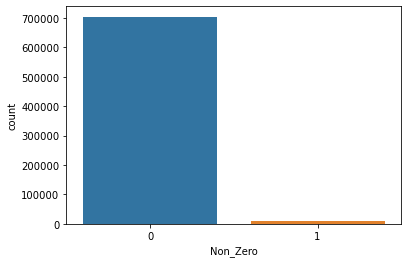

In [35]:
sns.countplot(x = 'Non_Zero', data = rev)
plt.show()

In [36]:
df_tmp = rev.copy()
df_tmp['Non_Zero'] = df_tmp['Non_Zero'].replace(to_replace=0,value='Doesn\'t Contribute') 
df_tmp['Non_Zero'] = df_tmp['Non_Zero'].replace(to_replace=1,value='Contributes') 
tmp_vc = df_tmp['Non_Zero'].value_counts()
tc = go.Pie(labels = tmp_vc.index, values = tmp_vc.values)
lt = go.Layout(title = "Revenue Distribution", height = 450)
fig = go.Figure(data = [tc], layout = lt)
iplot(fig)

In [37]:
# Only a tiny-sliver of the customers buy
count_buy = len(rev[rev['Non_Zero'] == 1])
percent = np.round(count_buy*100/len(rev),2)

print(f"A total of only {count_buy} people buy merchandise in the past 1 year, which is just {percent}% of total")

A total of only 9996 people buy merchandise in the past 1 year, which is just 1.4% of total


In [38]:
df_date = df.groupby('date').sum()[['totals_hits','totals_pageviews','totals_bounces','totals_newVisits','totals_transactionRevenue']].reset_index()
df_date

,date,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue
0,2016-08-01,13006.0,9843.0,728.0,1238.0,6.116060e+09
1,2016-08-02,15522.0,11784.0,962.0,1656.0,1.361190e+09
2,2016-08-03,17726.0,13724.0,1390.0,2269.0,0.000000e+00
3,2016-08-04,16782.0,13326.0,1553.0,2581.0,1.182890e+09
4,2016-08-05,17247.0,13585.0,1305.0,2156.0,5.594260e+09
...,...,...,...,...,...,...
361,2017-07-28,11192.0,9359.0,1185.0,1833.0,4.709440e+09
362,2017-07-29,7614.0,6293.0,815.0,1265.0,1.045010e+09
363,2017-07-30,8768.0,7258.0,913.0,1382.0,2.254160e+09
364,2017-07-31,13643.0,11115.0,1289.0,1874.0,1.141544e+10


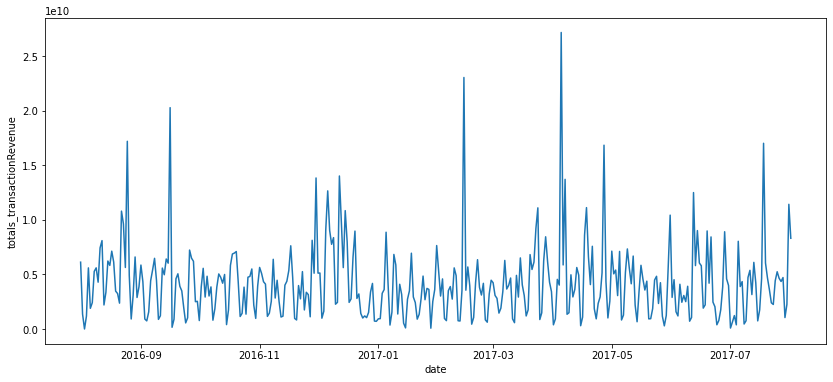

In [39]:
plt.figure(figsize=(14,6))
sns.lineplot(x='date',y='totals_transactionRevenue',data=df_date)
plt.show()

In [40]:
df_date = df_date.sort_values(by='totals_transactionRevenue',ascending=False)
df_date.head()

,date,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue
247,2017-04-05,10908.0,9193.0,1371.0,2001.0,2.715061e+10
197,2017-02-14,11148.0,9617.0,1196.0,1805.0,2.302837e+10
46,2016-09-16,16673.0,13261.0,1240.0,1967.0,2.026647e+10
24,2016-08-25,18048.0,14374.0,1223.0,1921.0,1.718621e+10
351,2017-07-18,13641.0,11386.0,1340.0,2046.0,1.700296e+10


In [41]:
df_rev = df.groupby('fullVisitorId').sum()[['totals_hits','totals_pageviews','totals_bounces','totals_newVisits','totals_transactionRevenue']].reset_index()

In [42]:
df_rev['ln(rev)'] = np.log1p(df_rev['totals_transactionRevenue'])

In [43]:
df_rev.head()

,fullVisitorId,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue,ln(rev)
0,0000010278554503158,11.0,8.0,0.0,1.0,0.0,0.0
1,0000020424342248747,17.0,13.0,0.0,1.0,0.0,0.0
2,0000027376579751715,6.0,5.0,0.0,1.0,0.0,0.0
3,0000039460501403861,2.0,2.0,0.0,1.0,0.0,0.0
4,0000040862739425590,5.0,5.0,0.0,1.0,0.0,0.0


<AxesSubplot:xlabel='totals_hits', ylabel='ln(rev)'>

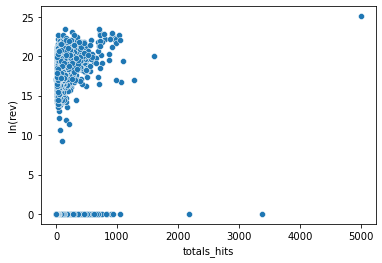

In [44]:
sns.scatterplot(x='totals_hits',y='ln(rev)',data=df_rev)

<AxesSubplot:xlabel='totals_pageviews', ylabel='ln(rev)'>

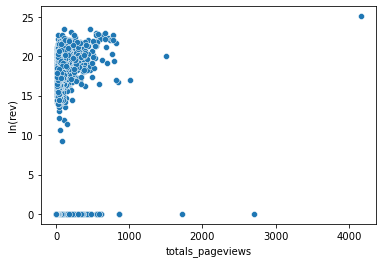

In [45]:
sns.scatterplot(x='totals_pageviews',y='ln(rev)',data=df_rev)

### Buyers

In [46]:
buyers = rev[rev['Non_Zero']==1].copy()
buyers.drop('Non_Zero',axis=1,inplace=True)
buyers['ln_rev'] = np.log1p(buyers['total_revenue'])
buyers.head()

,fullVisitorId,total_revenue,count,ln_rev
16,0000213131142648941,33590000.0,1,17.329739
168,0002871498069867123,96350000.0,3,18.383498
210,0003450834640354121,57950000.0,8,17.875091
257,0003961110741104601,4980000.0,2,15.420941
276,000435324061339869,44790000.0,3,17.617495


In [47]:
buyers['total_revenue'].sum()/1e9

1540.07124

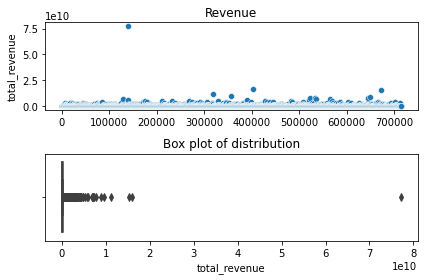

In [48]:
plt.subplot(2,1,1)
plt.title('Revenue')
sns.scatterplot(x=buyers.index,y=buyers.total_revenue)

plt.subplot(2,1,2)
plt.title('Box plot of distribution')
sns.boxplot(x = 'total_revenue', data = buyers)

plt.tight_layout()

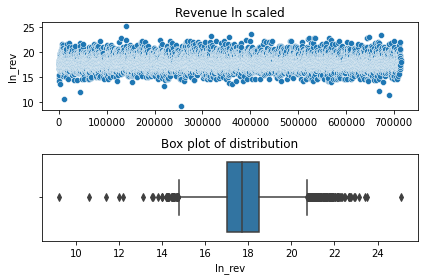

In [49]:
plt.subplot(2,1,1)
plt.title('Revenue ln scaled')
sns.scatterplot(x=buyers.index,y=buyers.ln_rev)

plt.subplot(2,1,2)
plt.title('Box plot of distribution')
sns.boxplot(x = 'ln_rev', data = buyers)

plt.tight_layout()

In [50]:
print("Distribution of revenue")
print("MIN revenue contributed = $",buyers['total_revenue'].min()/1e6,'M')
for i in [0.01,0.1,0.25,0.5,0.75,0.9,0.99]:
    qt = np.round(buyers['total_revenue'].quantile(i)/1e6,2)
    print(f'At {(i*100)} %ile, revenue = ${qt}M')
print("MAX revenue contributed = $",buyers['total_revenue'].max()/1e6,'M')
buyers = buyers.sort_values(by='total_revenue')

Distribution of revenue
MIN revenue contributed = $ 0.01 M
At 1.0 %ile, revenue = $2.99M
At 10.0 %ile, revenue = $15.02M
At 25.0 %ile, revenue = $24.49M
At 50.0 %ile, revenue = $48.84M
At 75.0 %ile, revenue = $108.46M
At 90.0 %ile, revenue = $282.12M
At 99.0 %ile, revenue = $1680.38M
MAX revenue contributed = $ 77113.43 M


In [51]:
buyers['Rev_Buckets'] = 'Under_3M'
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=3*1e6, r'3M_15M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=15*1e6, r'15M_25M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=25*1e6, r'25M_50M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=50*1e6, r'50M_100M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=100*1e6, r'100M_300M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=300*1e6, r'300M_1B', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=10*1e9, r'Over_1B', buyers['Rev_Buckets'])

In [52]:
model_class = buyers.copy() #For later use

<AxesSubplot:xlabel='Rev_Buckets', ylabel='count'>

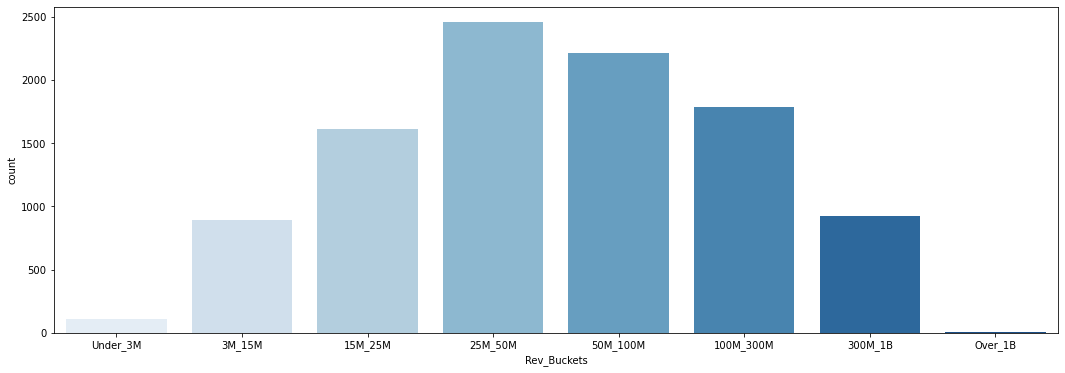

In [53]:
plt.figure(figsize=(18,6))
sns.countplot(x='Rev_Buckets',data=buyers,palette='Blues')

In [54]:
value_counts_tbl(buyers,'Rev_Buckets')

,vars,counts,percent
0,25M_50M,2455,0.245598
1,50M_100M,2215,0.221589
2,100M_300M,1785,0.178571
3,15M_25M,1612,0.161265
4,300M_1B,926,0.092637
5,3M_15M,891,0.089136
6,Under_3M,108,0.010804
7,Over_1B,4,0.000400


In [55]:
np.round(buyers.groupby('Rev_Buckets').sum()['total_revenue']/1e9,2) #In Billions

Rev_Buckets
100M_300M    295.97
15M_25M       31.38
25M_50M       89.14
300M_1B      837.05
3M_15M         9.20
50M_100M     157.59
Over_1B      119.52
Under_3M       0.22
Name: total_revenue, dtype: float64

In [56]:
(295.97 + 31.38 + 89.14 + 157.59)

574.08

#### Number of visits/transactions

In [57]:
buyers['count'].sum()

36110

In [58]:
buyers['count'].describe()

count    9996.000000
mean        3.612445
std         6.081394
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       278.000000
Name: count, dtype: float64

<AxesSubplot:xlabel='count'>

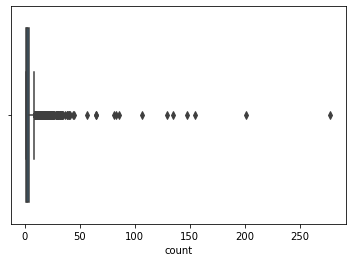

In [59]:
sns.boxplot(x='count',data=buyers)
#Outliers detected

In [60]:
print("Distribution of visits")
print("MIN visits = ",buyers['count'].min())
for i in [0.01,0.1,0.25,0.5,0.75,0.9,0.99]:
    qt = buyers['count'].quantile(i)
    print(f'At {(i*100)} %ile, count = {qt}')
print("MAX visits = ",buyers['count'].max())
buyers = buyers.sort_values(by='count')

Distribution of visits
MIN visits =  1
At 1.0 %ile, count = 1.0
At 10.0 %ile, count = 1.0
At 25.0 %ile, count = 1.0
At 50.0 %ile, count = 2.0
At 75.0 %ile, count = 4.0
At 90.0 %ile, count = 7.0
At 99.0 %ile, count = 21.0
MAX visits =  278


In [61]:
buyers['count_buckets'] = pd.cut(buyers['count'],[0,1,2,4,7,21,278])

<AxesSubplot:xlabel='count_buckets', ylabel='count'>

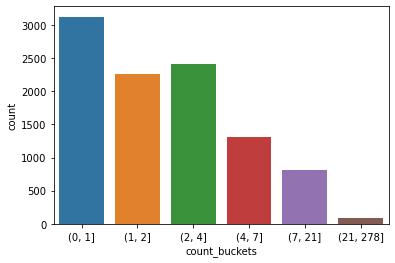

In [62]:
sns.countplot(x='count_buckets',data=buyers)

In [63]:
buyers['count_buckets'].value_counts(normalize=True)

(0, 1]       0.312125
(2, 4]       0.240696
(1, 2]       0.225890
(4, 7]       0.130352
(7, 21]      0.081733
(21, 278]    0.009204
Name: count_buckets, dtype: float64

In [64]:
buyers['count_buckets'].value_counts()

(0, 1]       3120
(2, 4]       2406
(1, 2]       2258
(4, 7]       1303
(7, 21]       817
(21, 278]      92
Name: count_buckets, dtype: int64

In [65]:
len(buyers)

9996

In [66]:
dff = pd.merge(left=df,right=buyers,on='fullVisitorId',how='left')
dff.set_index('fullVisitorId',inplace=True)
#dff.info()

In [67]:
dff['date'] = pd.to_datetime(dff['date'])
dff['transacted_yn'] = np.where(dff['totals_transactionRevenue']>0,1,0)

In [68]:
dff.head()

,channelGrouping,date,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,...,visitStartTime_hour,Date_month,Day,Day_num,total_revenue,count,ln_rev,Rev_Buckets,count_buckets,transacted_yn
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
1131660440785968503,Organic Search,2016-09-02,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,...,15,2016-09,Friday,4,NaN,NaN,NaN,NaN,NaN,0
377306020877927890,Organic Search,2016-09-02,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,...,5,2016-09,Friday,4,NaN,NaN,NaN,NaN,NaN,0
3895546263509774583,Organic Search,2016-09-02,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,desktop,...,1,2016-09,Friday,4,NaN,NaN,NaN,NaN,NaN,0
4763447161404445595,Organic Search,2016-09-02,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,desktop,...,5,2016-09,Friday,4,NaN,NaN,NaN,NaN,NaN,0
27294437909732085,Organic Search,2016-09-02,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,mobile,...,13,2016-09,Friday,4,NaN,NaN,NaN,NaN,NaN,0


In [69]:
df_buy = dff[~dff['Rev_Buckets'].isna()].copy()
df_buy.shape

(36110, 38)

In [70]:
df_buy = df_buy.reset_index()

__________

## EDA of customers who made a transaction

### HIGHEST transaction

In [71]:
#Assessing outliers
buyers[buyers['total_revenue'] == buyers['total_revenue'].max()]

,fullVisitorId,total_revenue,count,ln_rev,Rev_Buckets,count_buckets
139589,1957458976293878100,7.711343e+10,278,25.068543,Over_1B,"(21, 278]"


In [72]:
out = df_buy[df_buy['fullVisitorId'] == '1957458976293878100']
#out

In [73]:
df_viz = out.copy()

### Channel Grouping

In [74]:
pie_channelgroup(df_viz)
#pie_channelgroup(df_viz,1)
pie_channelgroup(df_viz,2)

### Device Details

In [75]:
plot_device(df_viz,flg=0)
#plot_device(df_viz,flg=1)
#plot_device(df_viz,flg=2)

### Geographic location

In [76]:
plot_geo(df_viz,flg=0)
#plot_geo(df_viz,flg=1)
#plot_geo(df_viz,flg=2)

### Domain

In [77]:
plot_Domain(df_viz)
plot_Domain(df_viz,flg=1)
#plot_Domain(df_viz,flg=2)

In [78]:
plot_Traffic(df_viz)
plot_Traffic(df_viz,flg=1)
plot_Traffic(df_viz,flg=2)

### Transaction at Hr. of the day

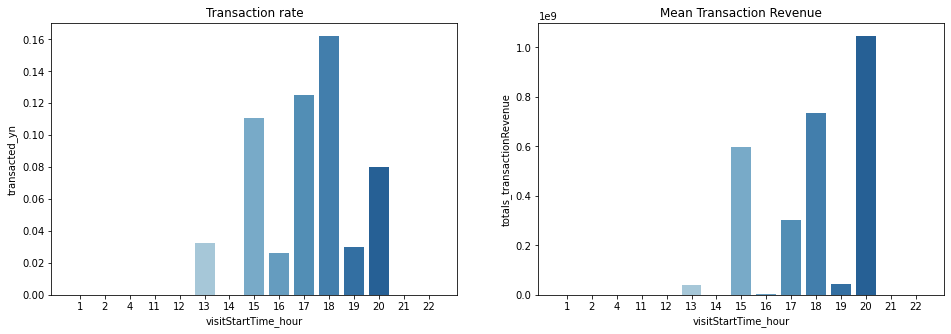

In [79]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst)

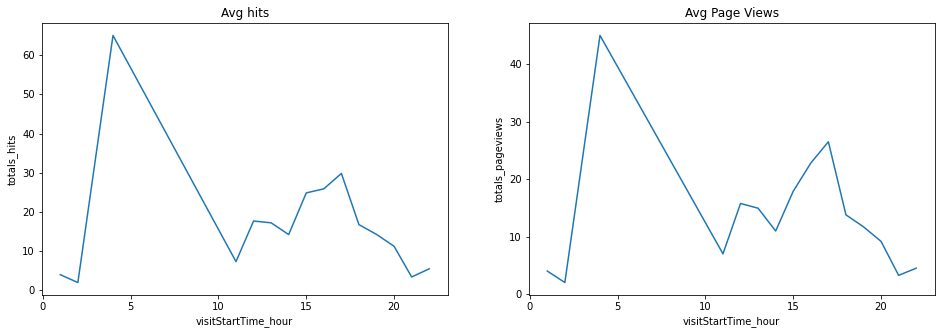

In [80]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

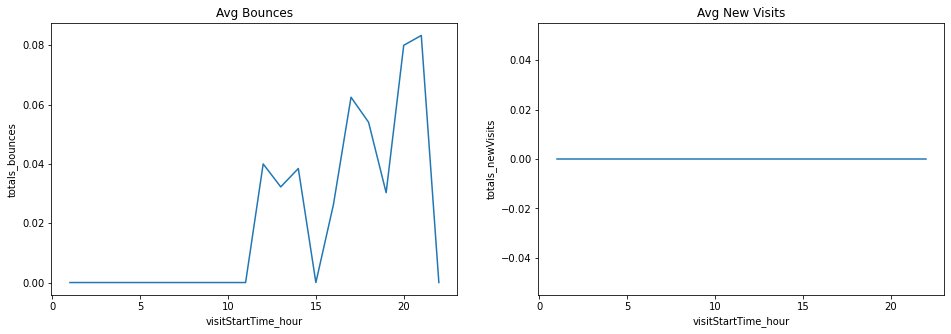

In [81]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

### Transaction at Day of the week level

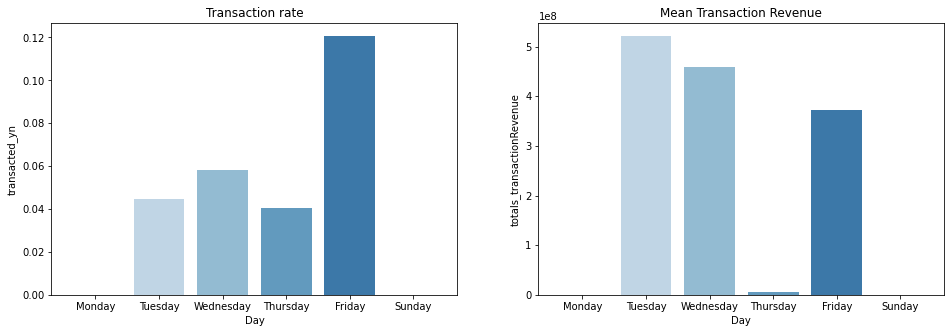

In [82]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst,flg='d')

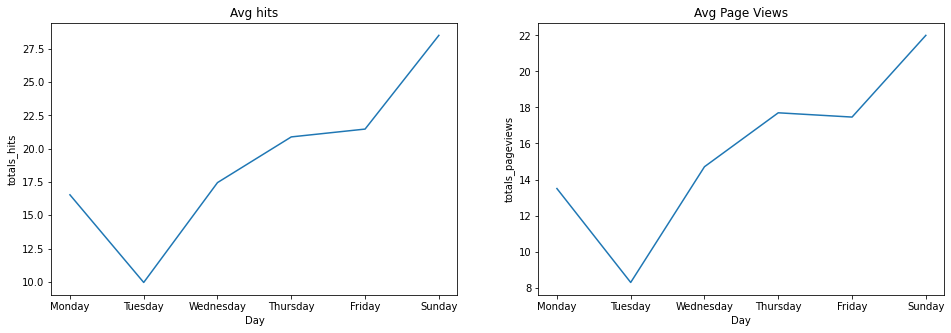

In [83]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

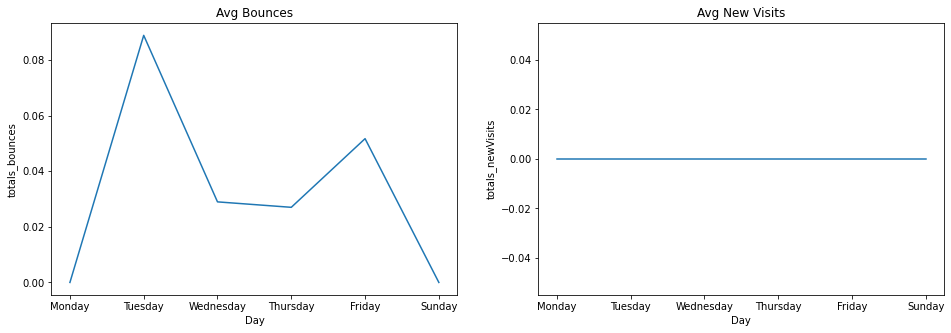

In [84]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

### Yearly transactions

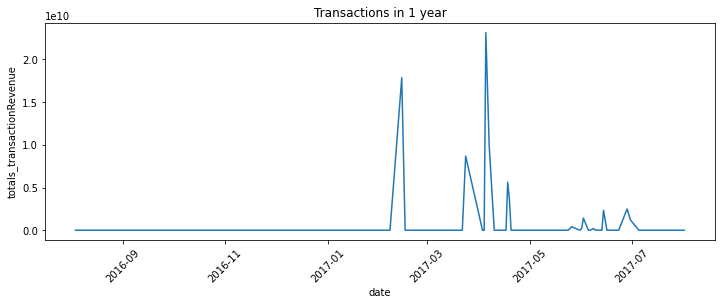

In [85]:
lab = "Transactions in 1 year"
plot_yr('totals_transactionRevenue',df_viz,lab)

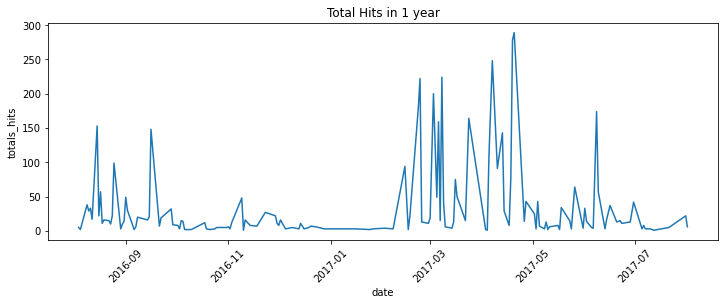

In [86]:
lab = "Total Hits in 1 year"
plot_yr('totals_hits',df_viz,lab)

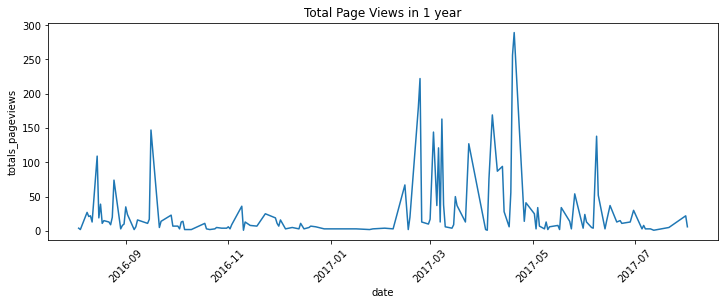

In [87]:
lab =  "Total Page Views in 1 year"
plot_yr('totals_pageviews',df_viz,lab)

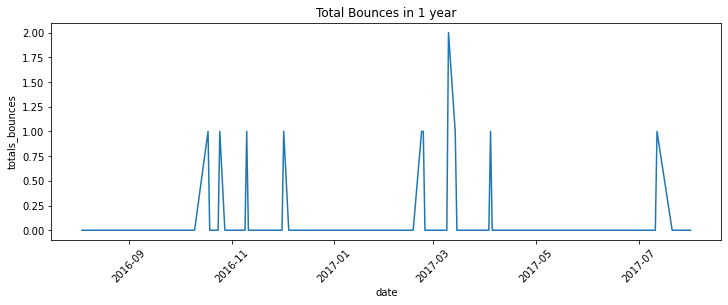

In [88]:
lab = "Total Bounces in 1 year"
plot_yr('totals_bounces',df_viz,lab)

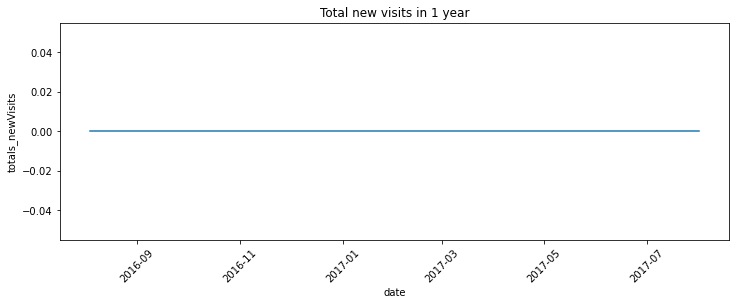

In [89]:
lab = "Total new visits in 1 year"
plot_yr('totals_newVisits',df_viz,lab)

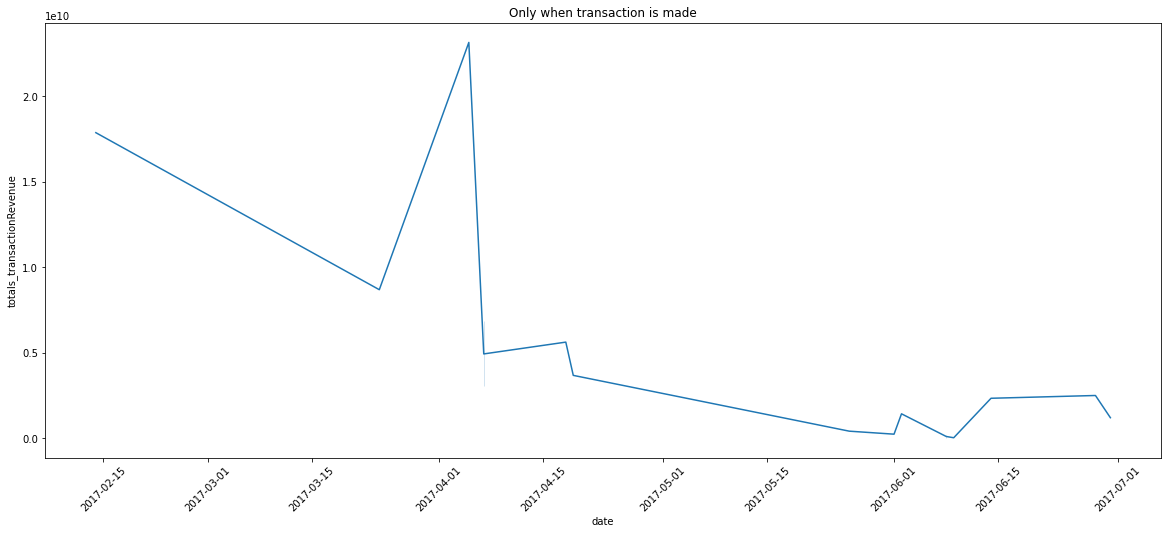

In [90]:
#Only when transaction is made
data_tmp = df_viz[df_viz['totals_transactionRevenue']!=0]
data_tmp = data_tmp.sort_values(by='date')

plt.figure(figsize=(20,8))
plt.title("Only when transaction is made")
sns.lineplot(x='date',y='totals_transactionRevenue',data=data_tmp)
plt.xticks(rotation=45)
plt.show()

#### Personalized view of that particular user

In [91]:
#Effect at day level
df_tmp = out.groupby(['Date_month','date','Day']).agg({'totals_hits':'sum',
                                                      'totals_pageviews':'sum',
                                                       'totals_bounces':'sum',
                                                       'totals_newVisits':'sum',
                                                       'totals_transactionRevenue':'sum',
                                                       'transacted_yn':'mean',
                                                       'visitNumber':'mean',
                                                       'fullVisitorId':'count'                                 
                                                      }).reset_index().rename({'fullVisitorId':'count_thatDate',
                                                                               'visitNumber':'avg_visitNumber',
                                                                               'totals_transactionRevenue':'total_revenue'
                                                                              },axis=1)

In [92]:
#df_tmp.sort_values('total_revenue',ascending=False)
df_tmp[df_tmp['total_revenue']!=0].sort_values(by='total_revenue',ascending=False)

,Date_month,date,Day,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,total_revenue,transacted_yn,avg_visitNumber,count_thatDate
96,2017-04,2017-04-05,Wednesday,110.0,76.0,0.0,0.0,2.312950e+10,0.250000,241.5,4
72,2017-02,2017-02-14,Tuesday,94.0,67.0,0.0,0.0,1.785550e+10,0.500000,181.5,2
97,2017-04,2017-04-07,Friday,248.0,169.0,0.0,0.0,9.849160e+09,0.666667,245.0,3
93,2017-03,2017-03-24,Friday,164.0,127.0,0.0,0.0,8.677830e+09,0.333333,236.0,3
102,2017-04,2017-04-18,Tuesday,77.0,56.0,0.0,0.0,5.614440e+09,1.000000,258.0,1
103,2017-04,2017-04-19,Wednesday,278.0,256.0,0.0,0.0,3.670920e+09,0.333333,260.0,3
134,2017-06,2017-06-28,Wednesday,13.0,13.0,0.0,0.0,2.495000e+09,0.500000,311.5,2
129,2017-06,2017-06-14,Wednesday,17.0,15.0,0.0,0.0,2.332560e+09,1.000000,305.0,1
123,2017-06,2017-06-02,Friday,14.0,13.0,0.0,0.0,1.424250e+09,1.000000,296.0,1
135,2017-06,2017-06-30,Friday,42.0,30.0,0.0,0.0,1.196740e+09,1.000000,315.0,1


_____________

## MINIMUM TRANSACTION

In [93]:
#Assessing outliers
buyers[buyers['total_revenue'] == buyers['total_revenue'].min()]

,fullVisitorId,total_revenue,count,ln_rev,Rev_Buckets,count_buckets
254495,3568593840277988902,10000.0,4,9.21044,Under_3M,"(2, 4]"


In [94]:
outn = df_buy[df_buy['fullVisitorId'] == '3568593840277988902']

In [95]:
df_viz = outn.copy()

### Channel Grouping

In [96]:
pie_channelgroup(df_viz)
pie_channelgroup(df_viz,1)
pie_channelgroup(df_viz,2)

### Device Details

In [97]:
plot_device(df_viz,flg=0)
#plot_device(df_viz,flg=1)
#plot_device(df_viz,flg=2)

### Geographic location

In [98]:
plot_geo(df_viz,flg=0)
#plot_geo(df_viz,flg=1)
#plot_geo(df_viz,flg=2)

### Domain

In [99]:
plot_Domain(df_viz)
plot_Domain(df_viz,flg=1)
#plot_Domain(df_viz,flg=2)

In [100]:
#plot_Traffic(df_viz)
plot_Traffic(df_viz,flg=1)
#plot_Traffic(df_viz,flg=2)

### Transaction at Hr. of the day

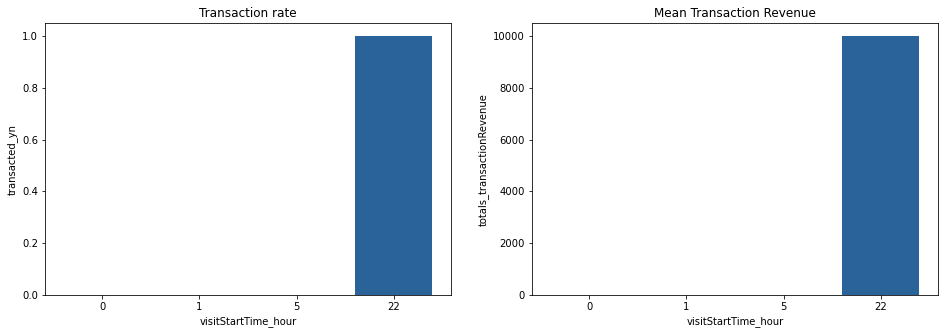

In [101]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst)

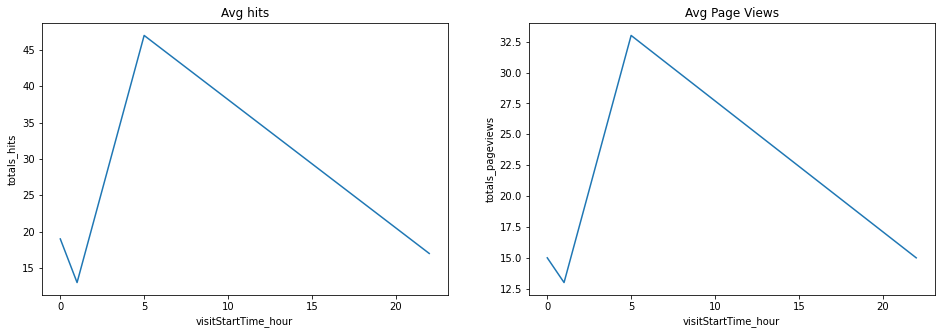

In [102]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

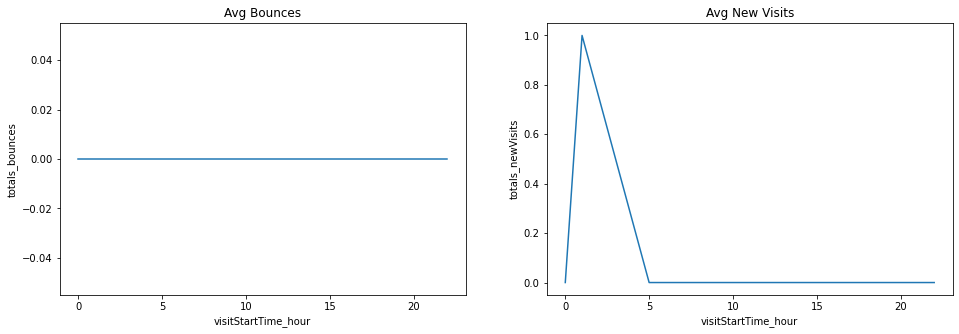

In [103]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

### Transaction at Day of the week level

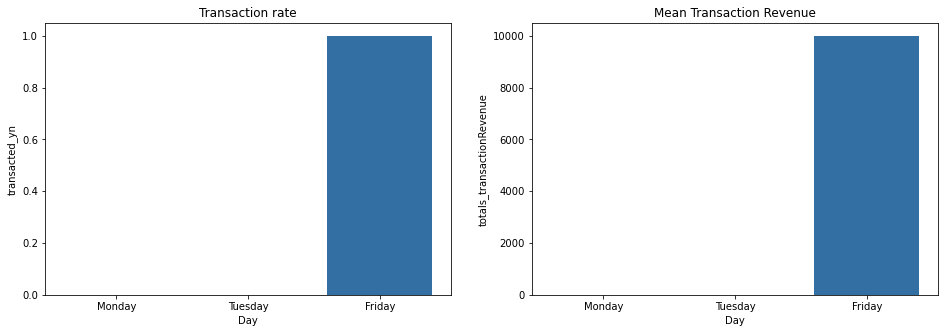

In [104]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst,flg='d')

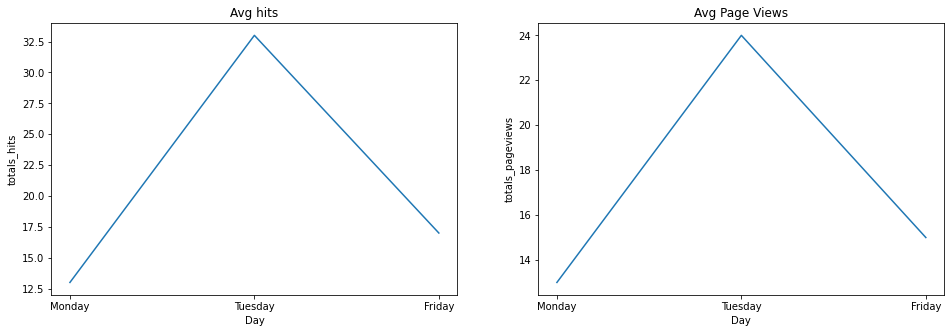

In [105]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

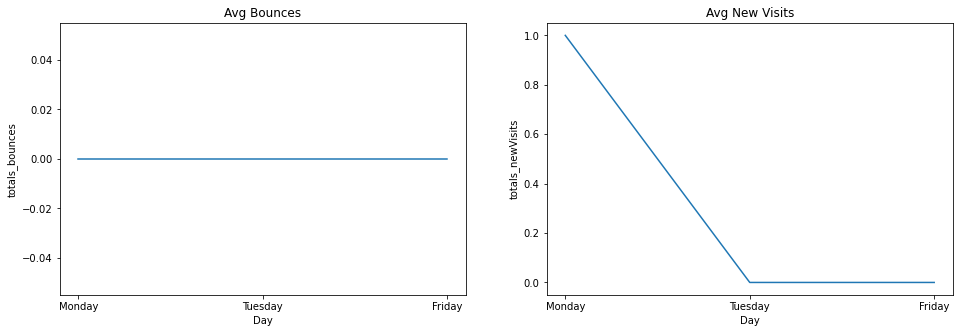

In [106]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

### Yearly transactions

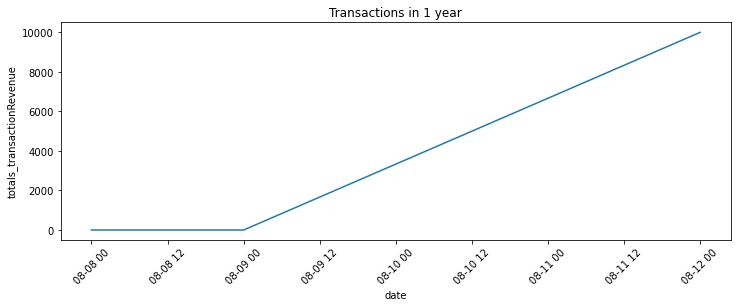

In [107]:
lab = "Transactions in 1 year"
plot_yr('totals_transactionRevenue',df_viz,lab)

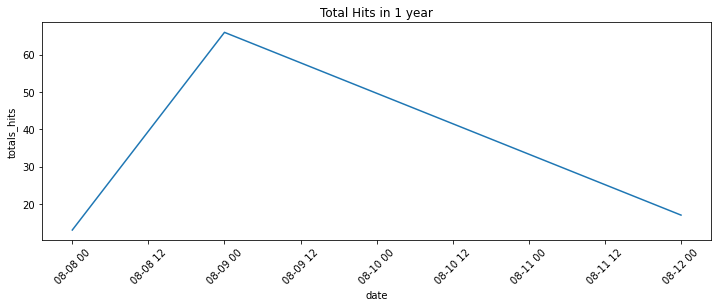

In [108]:
lab = "Total Hits in 1 year"
plot_yr('totals_hits',df_viz,lab)

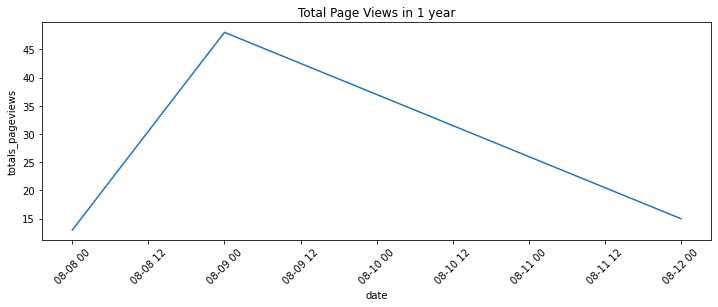

In [109]:
lab =  "Total Page Views in 1 year"
plot_yr('totals_pageviews',df_viz,lab)

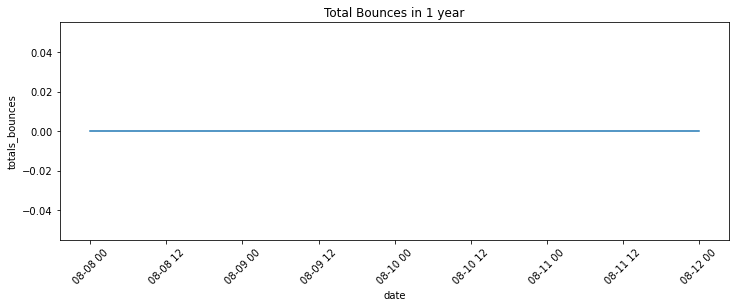

In [110]:
lab = "Total Bounces in 1 year"
plot_yr('totals_bounces',df_viz,lab)

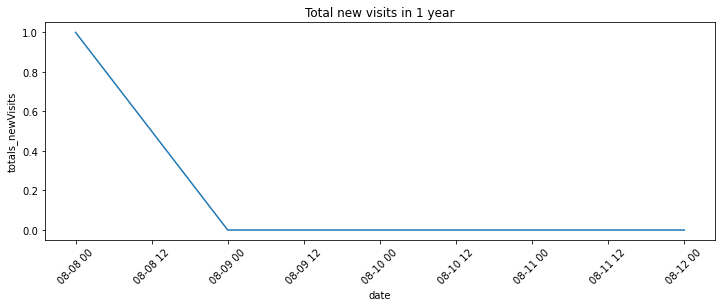

In [111]:
lab = "Total new visits in 1 year"
plot_yr('totals_newVisits',df_viz,lab)

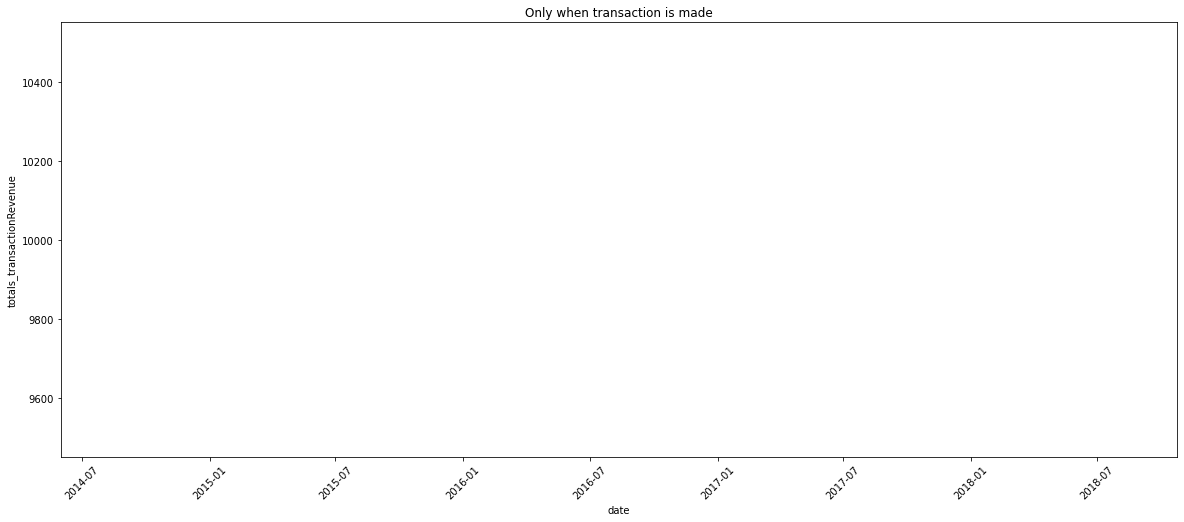

In [112]:
#Only when transaction is made
data_tmp = df_viz[df_viz['totals_transactionRevenue']!=0]
data_tmp = data_tmp.sort_values(by='date')

plt.figure(figsize=(20,8))
plt.title("Only when transaction is made")
sns.lineplot(x='date',y='totals_transactionRevenue',data=data_tmp)
plt.xticks(rotation=45)
plt.show()

#### Personalized view of that particular user

In [113]:
#Effect at day level
df_tmp = df_viz.groupby(['Date_month','date','Day']).agg({'totals_hits':'sum',
                                                      'totals_pageviews':'sum',
                                                       'totals_bounces':'sum',
                                                       'totals_newVisits':'sum',
                                                       'totals_transactionRevenue':'sum',
                                                       'transacted_yn':'mean',
                                                       'visitNumber':'mean',
                                                       'fullVisitorId':'count'                                 
                                                      }).reset_index().rename({'fullVisitorId':'count_thatDate',
                                                                               'visitNumber':'avg_visitNumber',
                                                                               'totals_transactionRevenue':'total_revenue'
                                                                              },axis=1)

In [114]:
#df_tmp.sort_values('total_revenue',ascending=False)
df_tmp[df_tmp['total_revenue']!=0].sort_values(by='total_revenue',ascending=False)

,Date_month,date,Day,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,total_revenue,transacted_yn,avg_visitNumber,count_thatDate
2,2016-08,2016-08-12,Friday,17.0,15.0,0.0,0.0,10000.0,1.0,4.0,1


______________

___________________

### For 1-99 %ile
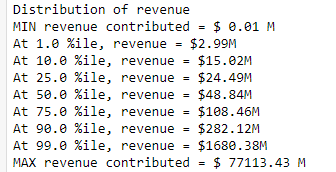

In [115]:
a10_90 = df_buy[(df_buy['total_revenue']<=df_buy['total_revenue'].max())&(df_buy['total_revenue']>=3*1e6)]
a10_90.shape

(35860, 39)

In [116]:
a10_90.to_csv('a10902.csv',index=False)

In [117]:
df_viz = a10_90.copy()

### Channel Grouping

In [118]:
pie_channelgroup(df_viz)
pie_channelgroup(df_viz,1)
pie_channelgroup(df_viz,2)

### Device Details

In [119]:
plot_device(df_viz,flg=0)
plot_device(df_viz,flg=1)
plot_device(df_viz,flg=2)

### Geographic location

In [120]:
plot_geo(df_viz,flg=0)
plot_geo(df_viz,flg=1)
plot_geo(df_viz,flg=2)

### Domain

In [121]:
plot_Domain(df_viz)
plot_Domain(df_viz,flg=1)
plot_Domain(df_viz,flg=2)

In [122]:
plot_Traffic(df_viz)
plot_Traffic(df_viz,flg=1)
plot_Traffic(df_viz,flg=2)

### Transaction at Hr. of the day

In [123]:
a10_90['transacted_yn'].mean()

0.3180702732849972

In [124]:
a10_90['totals_transactionRevenue'].mean()/1e6

42.94072532069158

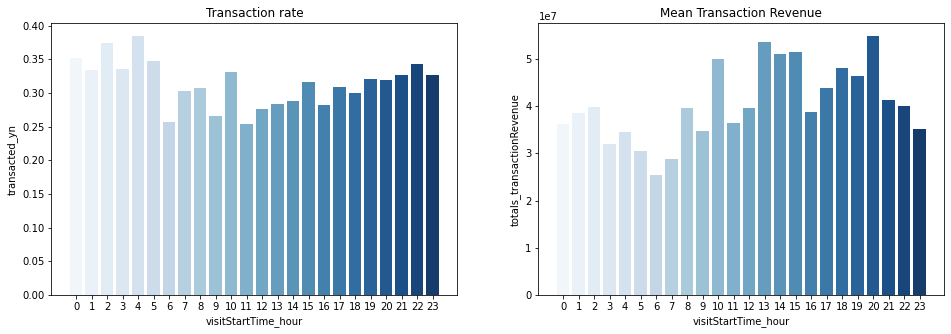

In [125]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst)

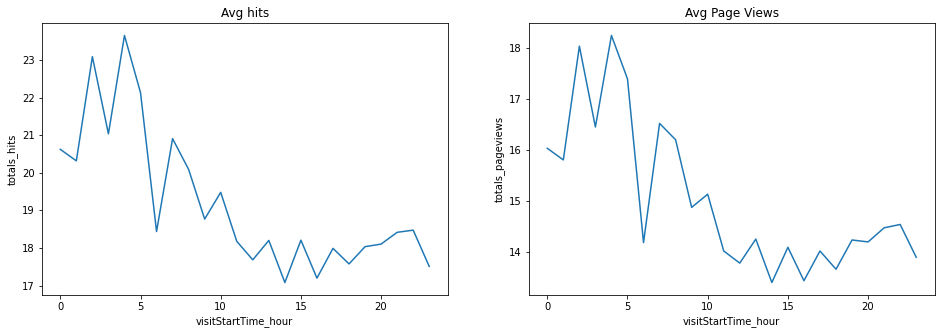

In [126]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

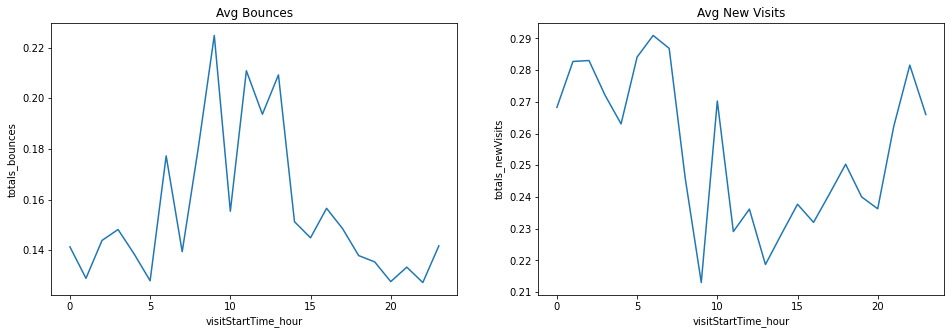

In [127]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line')

### Transaction at Day of the week level

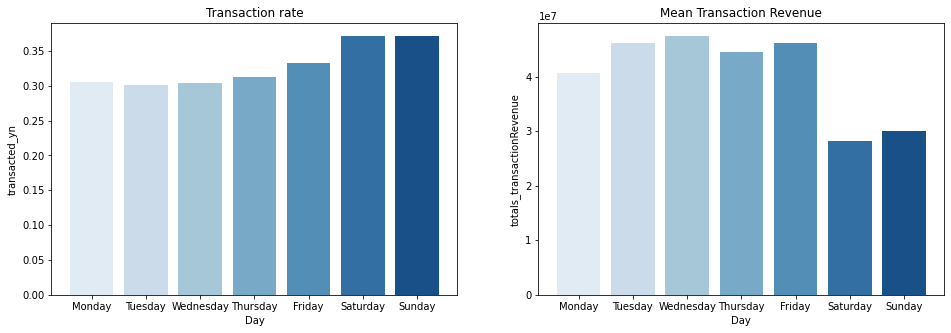

In [128]:
title_lst = ['Transaction rate','Mean Transaction Revenue']
var_lst = ['transacted_yn','totals_transactionRevenue']

subplot_at_mean_hr(df_viz,title_lst,var_lst,flg='d')

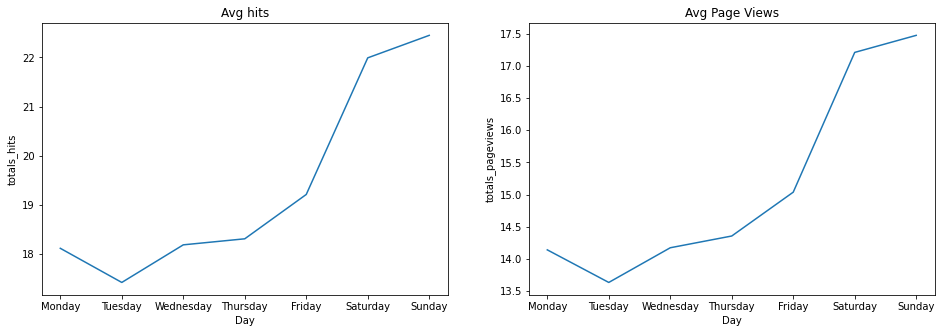

In [129]:
title_lst = ['Avg hits','Avg Page Views']
var_lst = ['totals_hits', 'totals_pageviews']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

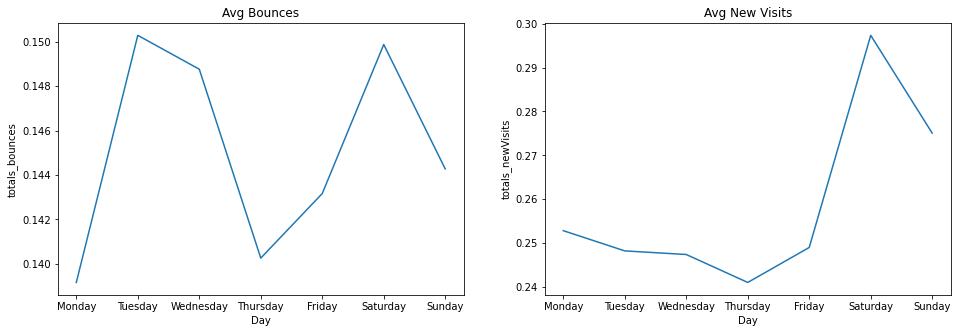

In [130]:
title_lst = ['Avg Bounces','Avg New Visits']
var_lst = ['totals_bounces', 'totals_newVisits']

subplot_at_mean_hr(df_viz,title_lst,var_lst,plott='line',flg='d')

### Yearly transactions

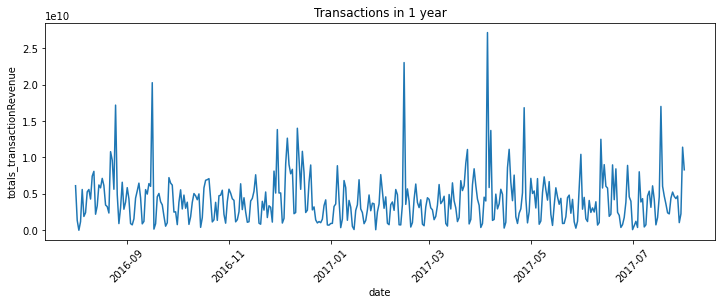

In [131]:
lab = "Transactions in 1 year"
plot_yr('totals_transactionRevenue',df_viz,lab)

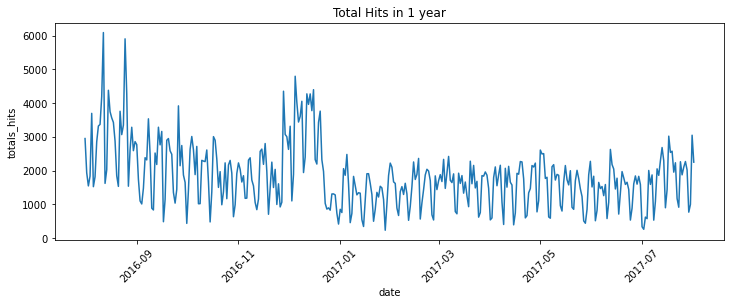

In [132]:
lab = "Total Hits in 1 year"
plot_yr('totals_hits',df_viz,lab)

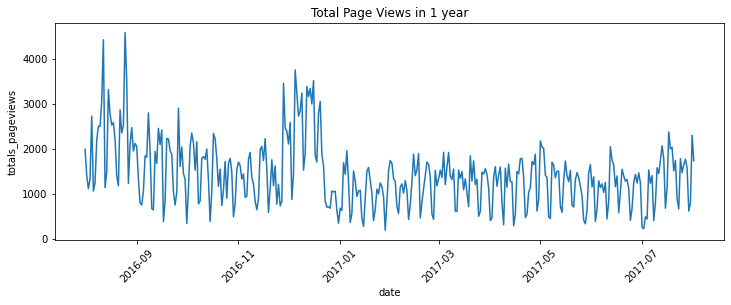

In [133]:
lab =  "Total Page Views in 1 year"
plot_yr('totals_pageviews',df_viz,lab)

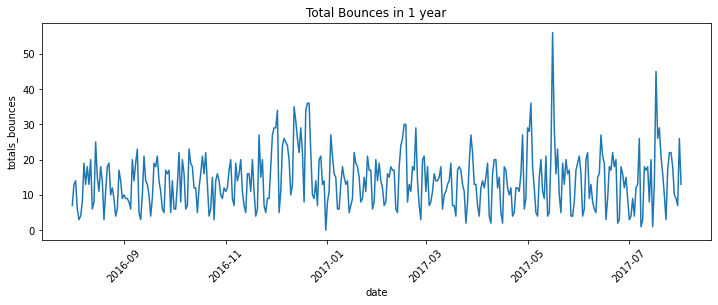

In [134]:
lab = "Total Bounces in 1 year"
plot_yr('totals_bounces',df_viz,lab)

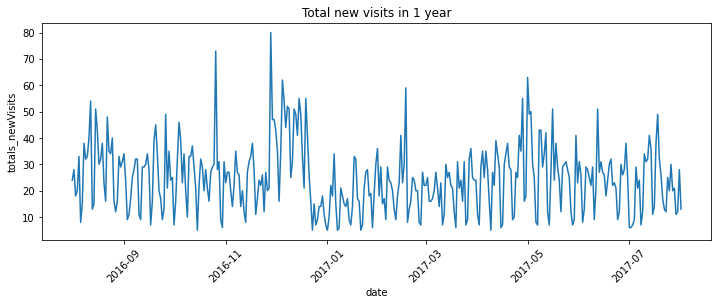

In [135]:
lab = "Total new visits in 1 year"
plot_yr('totals_newVisits',df_viz,lab)

Value_count table

In [136]:
value_counts_tbl(df_viz,'device_browser')

,vars,counts,percent
0,Chrome,32500,0.906302
1,Safari,2128,0.059342
2,Firefox,666,0.018572
3,Internet Explorer,390,0.010876
4,Edge,138,0.003848
5,Safari (in-app),17,0.000474
6,Opera,10,0.000279
7,Android Webview,9,0.000251
8,Amazon Silk,2,0.000056


In [137]:
value_counts_tbl(df_viz,'device_operatingSystem')

,vars,counts,percent
0,Macintosh,19680,0.548801
1,Windows,7534,0.210095
2,Chrome OS,3258,0.090853
3,Linux,2317,0.064612
4,iOS,1545,0.043084
5,Android,1522,0.042443
6,Windows Phone,4,0.000112


In [138]:
value_counts_tbl(df_viz,'device_isMobile')

,vars,counts,percent
0,False,32762,0.913608
1,True,3098,0.086392


In [139]:
value_counts_tbl(df_viz,'device_deviceCategory')

,vars,counts,percent
0,desktop,32753,0.913358
1,mobile,2682,0.074791
2,tablet,425,0.011852


In [140]:
value_counts_tbl(df_viz,'geoNetwork_continent')

,vars,counts,percent
0,Americas,34991,0.975767
1,Asia,532,0.014835
2,Europe,241,0.006721
3,Africa,49,0.001366
4,Oceania,38,0.001060
5,(not set),9,0.000251


In [141]:
value_counts_tbl(df_viz,'geoNetwork_country')

,vars,counts,percent
0,United States,33875,0.944646
1,Canada,671,0.018712
2,Venezuela,190,0.005298
3,Taiwan,91,0.002538
4,Singapore,80,0.002231
...,...,...,...
68,Curaçao,1,0.000028
69,Finland,1,0.000028
70,Austria,1,0.000028
71,Portugal,1,0.000028


In [142]:
value_counts_tbl(df_viz,'geoNetwork_region')

,vars,counts,percent
0,California,10495,0.483217
1,New York,4424,0.203693
2,Illinois,1256,0.057830
3,Washington,946,0.043556
4,Texas,886,0.040794
...,...,...,...
77,Pichincha,1,0.000046
78,Dublin City,1,0.000046
79,Wisconsin,1,0.000046
80,Antioquia,1,0.000046


In [143]:
df_viz.columns

Index(['fullVisitorId', 'channelGrouping', 'date', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city',
       'geoNetwork_networkDomain', 'totals_hits', 'totals_pageviews',
       'totals_bounces', 'totals_newVisits', 'totals_transactionRevenue',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_isTrueDirect', 'trafficSource_referralPath',
       'visitStartTime_hour', 'Date_month', 'Day', 'Day_num', 'total_revenue',
       'count', 'ln_rev', 'Rev_Buckets', 'count_buckets', 'transacted_yn'],
      dtype='object')

In [144]:
value_counts_tbl(df_viz,'trafficSource_campaign')

,vars,counts,percent
0,(not set),34509,0.962326
1,AW - Dynamic Search Ads Whole Site,926,0.025823
2,AW - Accessories,378,0.010541
3,Data Share Promo,33,0.000920
4,test-liyuhz,6,0.000167
5,AW - Electronics,5,0.000139
6,AW - Apparel,2,0.000056
7,Retail (DO NOT EDIT owners nophakun and tianyu),1,0.000028


In [145]:
value_counts_tbl(df_viz,'geoNetwork_city')

,vars,counts,percent
0,New York,4423,0.203647
1,Mountain View,4285,0.197293
2,San Francisco,2092,0.096321
3,Sunnyvale,1347,0.062019
4,Chicago,1255,0.057784
...,...,...,...
148,Jacksonville,1,0.000046
149,Stanford,1,0.000046
150,Carrollton,1,0.000046
151,Tbilisi,1,0.000046


In [146]:
value_counts_tbl(df_viz,'geoNetwork_networkDomain')

,vars,counts,percent
0,(not set),20834,0.580982
1,comcast.net,2604,0.072616
2,comcastbusiness.net,1504,0.041941
3,unknown.unknown,1348,0.037591
4,rr.com,1286,0.035862
...,...,...,...
901,ko.com,1,0.000028
902,providenet.com,1,0.000028
903,otenet.gr,1,0.000028
904,richmond.edu,1,0.000028


For those who made a transaction

In [147]:
a3 = df_viz[df_viz['totals_transactionRevenue']!=0].copy()

In [148]:
value_counts_tbl(a3,'device_browser')

,vars,counts,percent
0,Chrome,10273,0.900666
1,Safari,756,0.066281
2,Firefox,187,0.016395
3,Internet Explorer,109,0.009556
4,Edge,57,0.004997
5,Safari (in-app),12,0.001052
6,Android Webview,6,0.000526
7,Opera,5,0.000438
8,Amazon Silk,1,0.000088


In [149]:
value_counts_tbl(a3,'device_operatingSystem')

,vars,counts,percent
0,Macintosh,6382,0.559530
1,Windows,2286,0.200421
2,Chrome OS,990,0.086796
3,Linux,775,0.067947
4,iOS,517,0.045327
5,Android,455,0.039891
6,Windows Phone,1,0.000088


In [150]:
value_counts_tbl(a3,'device_isMobile')

,vars,counts,percent
0,False,10417,0.913291
1,True,989,0.086709


In [151]:
value_counts_tbl(a3,'device_deviceCategory')

,vars,counts,percent
0,desktop,10418,0.913379
1,mobile,822,0.072067
2,tablet,166,0.014554


In [152]:
value_counts_tbl(a3,'geoNetwork_continent')

,vars,counts,percent
0,Americas,11176,0.979835
1,Asia,124,0.010871
2,Europe,78,0.006839
3,Oceania,14,0.001227
4,Africa,8,0.000701
5,(not set),6,0.000526


In [153]:
value_counts_tbl(a3,'geoNetwork_country')

,vars,counts,percent
0,United States,10849,0.951166
1,Canada,189,0.016570
2,Venezuela,63,0.005523
3,Mexico,20,0.001753
4,Taiwan,19,0.001666
...,...,...,...
64,Pakistan,1,0.000088
65,Egypt,1,0.000088
66,Hungary,1,0.000088
67,Uruguay,1,0.000088


In [154]:
value_counts_tbl(a3,'geoNetwork_region')

,vars,counts,percent
0,California,3275,0.475741
1,New York,1500,0.217897
2,Illinois,422,0.061302
3,Washington,335,0.048664
4,Texas,299,0.043434
...,...,...,...
72,Kanagawa Prefecture,1,0.000145
73,Attica,1,0.000145
74,Gujarat,1,0.000145
75,Bucharest,1,0.000145


In [155]:
value_counts_tbl(a3,'geoNetwork_city')

,vars,counts,percent
0,New York,1499,0.217751
1,Mountain View,1202,0.174608
2,San Francisco,721,0.104736
3,Sunnyvale,452,0.065660
4,Chicago,421,0.061156
...,...,...,...
127,Dundalk,1,0.000145
128,Bellevue,1,0.000145
129,North Attleborough,1,0.000145
130,Indianapolis,1,0.000145


In [156]:
value_counts_tbl(a3,'geoNetwork_networkDomain')

,vars,counts,percent
0,(not set),6590,0.577766
1,comcast.net,925,0.081098
2,verizon.net,465,0.040768
3,unknown.unknown,394,0.034543
4,rr.com,361,0.031650
...,...,...,...
721,tmemccarngwil.com,1,0.000088
722,megapath.net,1,0.000088
723,paradisenetworks.net,1,0.000088
724,du.edu,1,0.000088


In [157]:
dff['device_deviceCategory'].value_counts()

desktop    664479
mobile     208725
tablet      30449
Name: device_deviceCategory, dtype: int64

_________

## > 90% ile

### Channel Grouping

### Device Details

### Geographic location

### Domain

### Transaction at Hr. of the day

### Transaction at Day of the week level

### Yearly transactions

_____________

______________________

_____________________

## < 10% ile

### Channel Grouping

### Device Details

### Geographic location

### Domain

### Transaction at Hr. of the day

### Transaction at Day of the week level

### Yearly transactions

____________

__________________

## Feature Engg.

In [158]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903653 entries, 1131660440785968503 to 0814900163617805053
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   channelGrouping             903653 non-null  object        
 1   date                        903653 non-null  datetime64[ns]
 2   sessionId                   903653 non-null  object        
 3   visitId                     903653 non-null  int64         
 4   visitNumber                 903653 non-null  int64         
 5   visitStartTime              903653 non-null  int64         
 6   device_browser              903653 non-null  object        
 7   device_operatingSystem      903653 non-null  object        
 8   device_isMobile             903653 non-null  bool          
 9   device_deviceCategory       903653 non-null  object        
 10  geoNetwork_continent        903653 non-null  object        
 11  geoNetwork_su

In [159]:
def prep_data(df_tmp,flg=0):
    
    
    df_tmp['visitStartTime_hour'] = df_tmp['visitStartTime_hour'].astype(float)
    
    df_tmp['traffic_camp'] = np.where(df_tmp['trafficSource_campaign'] == '(not set)',1,0)
    #df_tmp['traffic_med_org'] = np.where(df_tmp['trafficSource_medium']=='organic',1,0) 
    df_tmp['traffic_med_ref'] = np.where(df_tmp['trafficSource_medium']=='referral',1,0)
    
    
    df_tmp['device_browser_Chrome'] = np.where(df_tmp['device_browser'] == 'Chrome', 1, 0)
    df_tmp['device_browser_Safari'] = np.where(df_tmp['device_browser'] == 'Safari', 1, 0)
    df_tmp['device_browser_Firefox'] = np.where(df_tmp['device_browser'] == 'Firefox', 1, 0)
    
    df_tmp['device_operatingSystem_Win'] = np.where(df_tmp['device_operatingSystem'] == 'Windows', 1, 0)
    df_tmp['device_operatingSystem_Mac'] = np.where(df_tmp['device_operatingSystem'] == 'Macintosh', 1, 0)
    df_tmp['device_operatingSystem_And'] = np.where(df_tmp['device_operatingSystem'] == 'Android', 1, 0)
    
    df_tmp['geo_continent_Americas'] = np.where(df_tmp['geoNetwork_continent']=='Americas',1,0)
    df_tmp['geo_region_Cali'] = np.where(df_tmp['geoNetwork_region']=='California',1,0)
    df_tmp['geo_region_NY'] = np.where(df_tmp['geoNetwork_region']=='New York',1,0)
    
    df_tmp['geo_domain_notset'] = np.where(df_tmp['geoNetwork_networkDomain']=='(not set)',1,0)
    df_tmp['geo_domain_unknown'] = np.where(df_tmp['geoNetwork_networkDomain']=='unknown.unknown',1,0)
    
    
    feature_lst = ['fullVisitorId','visitStartTime_hour','visitNumber','visitStartTime',
                   'Day_num',#'month_num',
                   'totals_hits','totals_pageviews','totals_bounces','totals_newVisits',
                   'traffic_camp','traffic_med_ref',#'traffic_med_org',
                  'device_browser_Chrome','device_browser_Safari','device_browser_Firefox',
                  'device_operatingSystem_Win','device_operatingSystem_Mac','device_operatingSystem_And',
                  'geo_continent_Americas','geo_region_Cali','geo_region_NY',
                  'geo_domain_notset','geo_domain_unknown']
    
    
    if flg==0:
        df_tmp['select'] = np.where(df_tmp['Rev_Buckets'].isna(),0,1)
        feature_lst.append('select')
        
    d_dc = pd.get_dummies(df_tmp['device_deviceCategory'],prefix='device_')
    d_cg = pd.get_dummies(df_tmp['channelGrouping'],prefix='channelG_')
    
    df_tmp = df_tmp[feature_lst]
    
    return pd.concat([df_tmp,d_dc,d_cg],axis=1)   

In [160]:
train = dff.copy()
train = train.reset_index()

In [161]:
#condition = train['Rev_Buckets'].isin(['Under_3M','Over_1B'])
#train.drop(train[condition].index)
df_train = prep_data(train)
df_train = pd.concat([df_train,train['totals_transactionRevenue']],axis=1)

In [162]:
# For test data - FEATURE ENGINEERING
test = prep_data(df_test,1)

In [163]:
df_train.shape

(903653, 35)

In [164]:
#df_train.columns

In [165]:
df_train['select'].value_counts()

0    867543
1     36110
Name: select, dtype: int64

### Handling Imbalance - Undersampling

In [166]:
df_p1 = df_train[df_train['select'] == 1].copy()
df_p2 = df_train[df_train['select'] == 0].copy()
df_p2 = df_p2.sample(n=36110)

In [167]:
df_t = pd.concat([df_p1,df_p2])
df_t.drop('select',axis=1,inplace=True)
df_t.set_index('fullVisitorId',inplace=True)
#df_t

______

## Predicting Revenue

In [168]:
X = df_t.drop('totals_transactionRevenue',axis=1)
Y = df_t['totals_transactionRevenue']
y = np.log1p(Y)

In [169]:
#X['Rev_Buckets'].value_counts()

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [171]:
y.value_counts(normalize=True)

0.000000     0.840557
16.648136    0.003545
16.759423    0.002617
17.329739    0.002589
17.617495    0.002354
               ...   
18.300319    0.000014
18.726694    0.000014
17.346273    0.000014
18.982637    0.000014
18.055253    0.000014
Name: totals_transactionRevenue, Length: 5333, dtype: float64

In [172]:
y_train.value_counts(normalize=True)

0.000000     0.840089
16.648136    0.003427
16.759423    0.002562
17.329739    0.002475
17.617495    0.002302
               ...   
17.064722    0.000017
17.816094    0.000017
18.880445    0.000017
17.999848    0.000017
17.231925    0.000017
Name: totals_transactionRevenue, Length: 4521, dtype: float64

In [173]:
y_test.value_counts(normalize=True)

0.000000     0.842426
16.648136    0.004016
17.329739    0.003046
16.759423    0.002839
17.617495    0.002562
               ...   
18.621170    0.000069
23.605577    0.000069
18.515172    0.000069
17.212700    0.000069
20.358847    0.000069
Name: totals_transactionRevenue, Length: 1435, dtype: float64

## KNN

In [174]:
# scaler = StandardScaler()
# scaled_X_train = scaler.fit_transform(X_train)
# scaled_X_test = scaler.transform(X_test)

# dict_knn = {'k':[],'accuracy':[]}
# for k in np.arange(2,100,8):
#     knn = KNeighborsRegressor(n_neighbors=k)
#     knn.fit(scaled_X_train, y_train)
    
#     acc_knn = knn.score(scaled_X_test, y_test)
    
#     dict_knn['k'].append(k)
#     dict_knn['accuracy'].append(acc_knn)
# sns.lineplot(x='k',y='accuracy',data=pd.DataFrame(dict_knn))

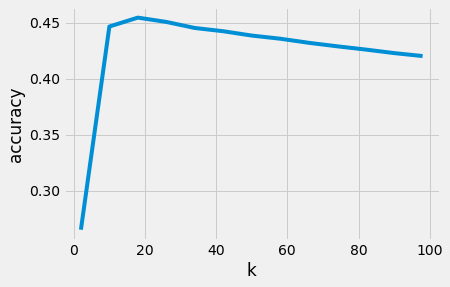

In [175]:
# knn = KNeighborsRegressor(n_neighbors=19)
# knn.fit(scaled_X_train, y_train)

# knn_preds = knn.predict(scaled_X_test)

# # RMSE Computation
# rmse = np.sqrt(MSE(y_test, knn_preds))
# print("RMSE : % f" %(rmse))
# pd.Series(knn_preds).value_counts(normalize=True)

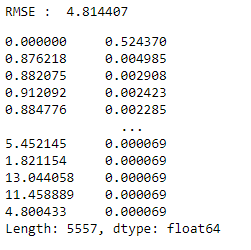

## XGBoost


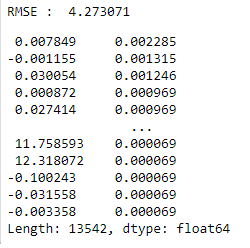

In [176]:
# xgb_r = XGBRegressor(objective ='reg:squarederror',
#                   n_estimators = 10, seed = 123)

# # Fitting the model
# xgb_r.fit(X_train, y_train)

# # Predict the model
# xxpred = xgb_r.predict(X_test)
  
# # RMSE Computation
# rmse = np.sqrt(MSE(y_test, xxpred))
# print("RMSE : % f" %(rmse))
# pd.Series(xxpred).value_counts(normalize=True)

### Random Forest

In [177]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))
pd.Series(pred).value_counts(normalize=True)

RMSE :  4.267018


0.000000     0.660690
0.174783     0.000831
0.151968     0.000831
0.174256     0.000762
0.171180     0.000692
               ...   
0.524498     0.000069
13.108878    0.000069
14.375199    0.000069
2.068254     0.000069
1.917223     0.000069
Length: 4641, dtype: float64

Random Forest model is performing ok-ish with a RMSE of 4.32

In [178]:
# Training the model on entire dataset
model_final = RandomForestRegressor(n_estimators=100, random_state=30)
model_final.fit(X,y)

RandomForestRegressor(random_state=30)

## For test dataset

In [179]:
X_test_final = test.copy()
X_test_final.set_index('fullVisitorId',inplace=True)

In [180]:
predictions = model_final.predict(X_test_final)

In [181]:
pd.Series(predictions).value_counts(normalize=True)

0.000000     0.683061
0.173791     0.055982
0.694180     0.019741
2.433075     0.011878
0.346597     0.011214
               ...   
12.445575    0.000001
3.855060     0.000001
10.698821    0.000001
11.518892    0.000001
3.442269     0.000001
Length: 78700, dtype: float64

In [182]:
X_test_final['preds_ln_rev'] = predictions
X_test_final['preds_rev'] = np.expm1(predictions)
X_test_final.reset_index(inplace=True)

In [183]:
X_test_final.head()

,fullVisitorId,visitStartTime_hour,visitNumber,visitStartTime,Day_num,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,traffic_camp,...,channelG__(Other),channelG__Affiliates,channelG__Direct,channelG__Display,channelG__Organic Search,channelG__Paid Search,channelG__Referral,channelG__Social,preds_ln_rev,preds_rev
0,6167871330617112363,10.0,2,1508151024,0,4.0,4.0,0.0,0.0,1,...,0,0,0,0,1,0,0,0,0.519404,0.681025
1,0643697640977915618,17.0,1,1508175522,0,5.0,5.0,0.0,1.0,1,...,0,0,0,0,1,0,0,0,2.433075,10.393869
2,6059383810968229466,8.0,1,1508143220,0,7.0,7.0,0.0,1.0,1,...,0,0,0,0,1,0,0,0,0.558686,0.748373
3,2376720078563423631,22.0,1,1508193530,0,8.0,4.0,0.0,1.0,1,...,0,0,0,0,1,0,0,0,0.866001,1.377384
4,2314544520795440038,5.0,1,1508217442,0,9.0,4.0,0.0,1.0,1,...,0,0,0,0,1,0,0,0,0.345612,0.412855


<AxesSubplot:xlabel='preds_rev'>

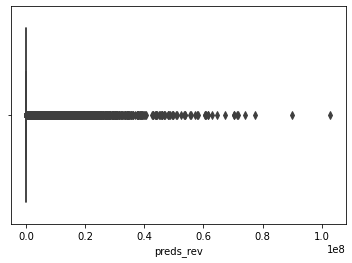

In [184]:
sns.boxplot(x = 'preds_rev' , data = X_test_final)

In [185]:
X_test_final.shape

(804684, 35)

In [186]:
X_test_final['preds_rev'].sum()/1e9

30.27193045390008

In [187]:
#sns.barplot(x=X_test_final.index,y=X_test_final['preds_rev'])

____________________________
___________________________
________________

### Merging with the main dataset

In [188]:
lst = ['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country',
       'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city',
       'geoNetwork_networkDomain', 'totals_hits', 'totals_pageviews',
       'totals_bounces', 'totals_newVisits', #'totals_transactionRevenue',
       'trafficSource_campaign', 'trafficSource_source',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_isTrueDirect', 'trafficSource_referralPath',
       'visitStartTime_hour', 'Date_month', 'Day', 'Day_num']

df_test2 = df_test[lst].copy()

In [189]:
df_predicted = pd.concat([df_test2,X_test_final['preds_rev']],axis=1)
df_predicted.rename({'preds_rev':'totals_transactionRevenue'},axis=1,inplace=True)
df_predicted.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_operatingSystem,device_isMobile,...,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_isTrueDirect,trafficSource_referralPath,visitStartTime_hour,Date_month,Day,Day_num,totals_transactionRevenue
0,Organic Search,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,Chrome,Macintosh,False,...,google,organic,(not provided),True,NA,10.0,2017-10,Monday,0,0.681025
1,Organic Search,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,Chrome,Windows,False,...,google,organic,(not provided),NA,NA,17.0,2017-10,Monday,0,10.393869
2,Organic Search,2017-10-16,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,Chrome,Macintosh,False,...,google,organic,(not provided),NA,NA,8.0,2017-10,Monday,0,0.748373
3,Organic Search,2017-10-16,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,Safari,iOS,True,...,google,organic,(not provided),NA,NA,22.0,2017-10,Monday,0,1.377384
4,Organic Search,2017-10-16,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,Safari,Macintosh,False,...,google,organic,(not provided),NA,NA,5.0,2017-10,Monday,0,0.412855


In [190]:
print("Total estimated transactions = $",df_predicted['totals_transactionRevenue'].sum()/1e9,'B')

Total estimated transactions = $ 30.27193045390008 B


In [191]:
print(f"Number of days on which a sale is made = {df_predicted['date'].nunique()}")
print(f"Sale Dates ranges from {df_predicted['date'].min()} to {df_predicted['date'].max()}")

Number of days on which a sale is made = 272
Sale Dates ranges from 2017-08-02 00:00:00 to 2018-04-30 00:00:00


#### Forecast is made for the next 9 months

In [192]:
rev = df_predicted.groupby('fullVisitorId').agg({'totals_transactionRevenue':'sum',
                                       'visitId':'count'
                                      }).reset_index()
rev = rev.rename({'totals_transactionRevenue':'total_revenue','visitId':'count'},axis=1)
rev['Non_Zero'] = np.where(rev['total_revenue']>0,1,0)

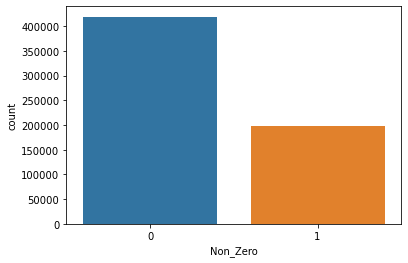

In [193]:
sns.countplot(x = 'Non_Zero', data = rev)
plt.show()

In [194]:
# Only a tiny-sliver of the customers buy
count_buy = len(rev[rev['Non_Zero'] == 1])
percent = np.round(count_buy*100/len(rev),2)

print(f"A total of only {count_buy} people will buy merchandise in the forecasted year, which is just {percent}% of total")

A total of only 198111 people will buy merchandise in the forecasted year, which is just 32.1% of total


### Buyers

In [195]:
buyers = rev[rev['Non_Zero']==1].copy()
buyers.drop('Non_Zero',axis=1,inplace=True)
buyers['ln_rev'] = np.log1p(buyers['total_revenue'])
buyers.head()

,fullVisitorId,total_revenue,count,ln_rev
0,0000000259678714014,3.491509e+02,2,5.858364
6,0000117255350596610,5.280148e+06,1,15.479465
7,0000118334805178127,1.898070e-01,1,0.173791
9,0000150005271820273,1.836998e+00,1,1.042747
10,0000166374699289385,1.255651e+01,1,2.606867


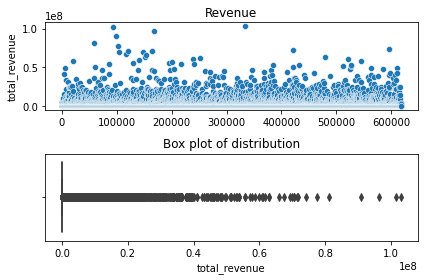

In [196]:
plt.subplot(2,1,1)
plt.title('Revenue')
sns.scatterplot(x=buyers.index,y=buyers.total_revenue)

plt.subplot(2,1,2)
plt.title('Box plot of distribution')
sns.boxplot(x = 'total_revenue', data = buyers)

plt.tight_layout()

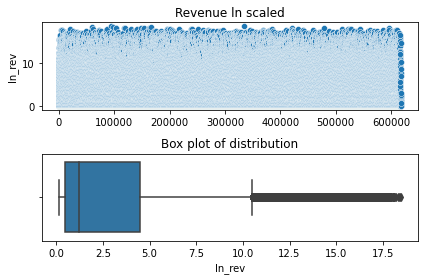

In [197]:
plt.subplot(2,1,1)
plt.title('Revenue ln scaled')
sns.scatterplot(x=buyers.index,y=buyers.ln_rev)

plt.subplot(2,1,2)
plt.title('Box plot of distribution')
sns.boxplot(x = 'ln_rev', data = buyers)

plt.tight_layout()

In [198]:
print("Distribution of revenue")
print("MIN revenue contributed = $",buyers['total_revenue'].min())
for i in [0.01,0.1,0.25,0.5,0.75,0.9,0.99]:
    qt = np.round(buyers['total_revenue'].quantile(i),2)
    print(f'At {(i*100)} %ile, revenue = ${qt}')
print("MAX revenue contributed = $",buyers['total_revenue'].max()/1e6,'M')
buyers = buyers.sort_values(by='total_revenue')

Distribution of revenue
MIN revenue contributed = $ 0.15281844220870872
At 1.0 %ile, revenue = $0.19
At 10.0 %ile, revenue = $0.19
At 25.0 %ile, revenue = $0.61
At 50.0 %ile, revenue = $2.41
At 75.0 %ile, revenue = $86.56
At 90.0 %ile, revenue = $10231.24
At 99.0 %ile, revenue = $3623102.71
MAX revenue contributed = $ 102.9132842094143 M


In [199]:
buyers['Rev_Buckets'] = 'Under_3M'
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=3*1e6, r'3M_15M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=15*1e6, r'15M_25M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=25*1e6, r'25M_50M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=50*1e6, r'50M_100M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=100*1e6, r'100M_300M', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=300*1e6, r'300M_1B', buyers['Rev_Buckets'])
buyers['Rev_Buckets'] = np.where(buyers['total_revenue']>=10*1e9, r'Over_1B', buyers['Rev_Buckets'])

<AxesSubplot:xlabel='Rev_Buckets', ylabel='count'>

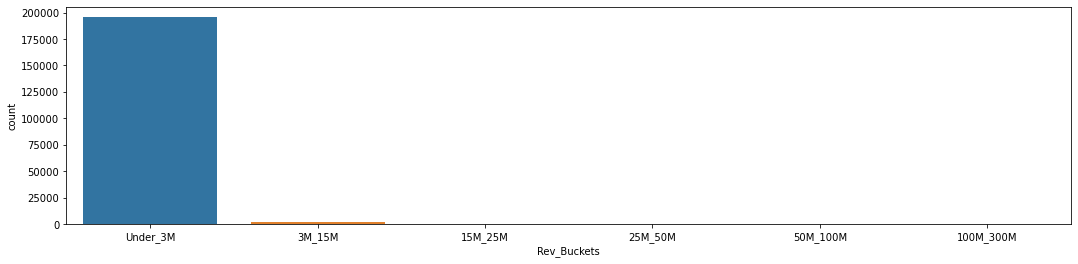

In [200]:
plt.figure(figsize=(18,4))
sns.countplot(x='Rev_Buckets',data=buyers)

In [201]:
value_counts_tbl(buyers,'Rev_Buckets')

,vars,counts,percent
0,Under_3M,195864,0.988658
1,3M_15M,1773,0.008950
2,15M_25M,295,0.001489
3,25M_50M,144,0.000727
4,50M_100M,33,0.000167
5,100M_300M,2,0.000010


___
_____
______

# Classification Model

In [220]:
from sklearn.neighbors import KNeighborsClassifier

In [221]:
def data_clean_class(X):
    X_df = X.reset_index()
    X_df = X_df.groupby('fullVisitorId').mean().reset_index()
    return X_df

In [222]:
X_df = data_clean_class(X)
X_df.shape

(45332, 33)

In [223]:
y_df = model_class[['fullVisitorId','Rev_Buckets']]
y_df.shape

(9996, 2)

In [224]:
#y_df['Rev_Buckets'].value_counts()

In [225]:
main_data = pd.merge(left = X_df, right=y_df, on = 'fullVisitorId',how='left')
main_data.set_index('fullVisitorId',inplace=True)
main_data['Rev_Buckets'].fillna('No_Revenue',inplace = True)
main_data['Rev_Buckets'].value_counts()

No_Revenue    35336
25M_50M        2455
50M_100M       2215
100M_300M      1785
15M_25M        1612
300M_1B         926
3M_15M          891
Under_3M        108
Over_1B           4
Name: Rev_Buckets, dtype: int64

In [226]:
x_data = main_data.drop('Rev_Buckets',axis=1)
y_data = main_data['Rev_Buckets'].copy()

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

In [227]:
# y_data.replace(to_replace='No_Revenue',value='0',inplace=True)
# y_data.replace(to_replace='Under_3M',value='1',inplace=True)
# y_data.replace(to_replace='3M_15M',value='2',inplace=True)
# y_data.replace(to_replace='15M_25M',value='3',inplace=True)
# y_data.replace(to_replace='25M_50M',value='4',inplace=True)
# y_data.replace(to_replace='50M_100M',value='5',inplace=True)
# y_data.replace(to_replace='100M_300M',value='6',inplace=True)
# y_data.replace(to_replace='300M_1B',value='7',inplace=True)
# y_data.replace(to_replace='Over_1B',value='8',inplace=True)
#y_data.value_counts()

In [228]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [229]:
knn_clf=KNeighborsClassifier(n_neighbors=20)

knn_clf.fit(scaled_X_train,y_train)
ypred=knn_clf.predict(scaled_X_test)

In [230]:
print("Accuracy = ",accuracy_score(y_test,ypred))
confusion_matrix(y_test, ypred)

Accuracy =  0.8039042682254329


array([[ 110,   23,   77,   34,    1,   67,   78,    0,    0],
       [  28,   33,   65,    2,    0,   31,  138,    0,    0],
       [  74,   48,  119,   16,    3,   80,  171,    0,    0],
       [  59,   11,   35,   27,    1,   18,   22,    0,    0],
       [  14,   29,   27,    0,    2,   14,   89,    0,    0],
       [  94,   33,  103,   22,    3,   83,  113,    0,    0],
       [  40,   23,   38,    9,    1,   22, 6915,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    3,    3,    0,    0,    5,    8,    0,    0]],
      dtype=int64)

### XGB Classifier

In [231]:
xgb = XGBClassifier(eval_metric='error')#, use_label_encoder=True)
xgb.fit(X_train, y_train)

print('Test accuracy: {:.4f}'.format(xgb.score(X_test, y_test)))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Test accuracy: 0.8224


In [232]:
#Making predictions
y_preds = xgb.predict(X_test)

In [233]:
print("Accuracy = ",accuracy_score(y_test,y_preds))
confusion_matrix(y_test, y_preds)

Accuracy =  0.8224329987868093


array([[  93,   20,   87,   47,    4,  107,   32,    0,    0],
       [  27,   64,   84,    8,    8,   55,   51,    0,    0],
       [  60,   60,  167,   25,    9,  123,   66,    0,    1],
       [  51,    8,   32,   48,    5,   25,    4,    0,    0],
       [  18,   37,   52,    1,   10,   27,   30,    0,    0],
       [  86,   32,  145,   26,    5,  112,   45,    0,    0],
       [   9,   19,   34,    2,    7,   14, 6963,    0,    0],
       [   0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   1,    5,    5,    1,    2,    4,    3,    0,    0]],
      dtype=int64)

In [234]:
#pd.Series(y_preds).value_counts()

### Feature importance

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


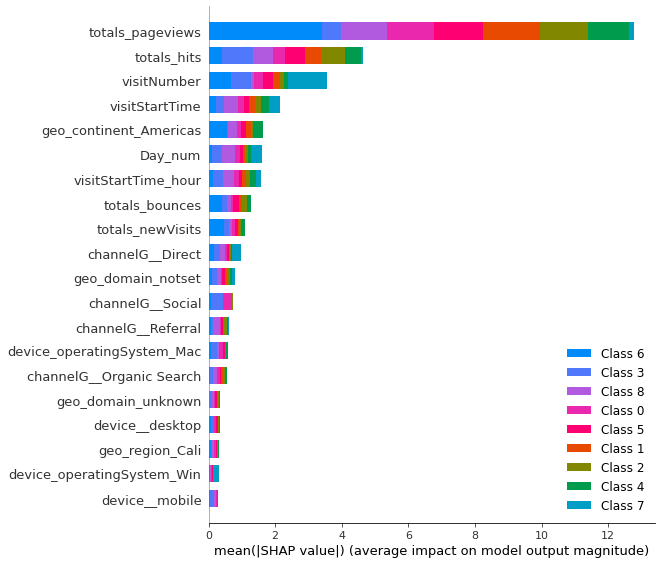

In [235]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Training the model on entire dataset

In [236]:
xgb = XGBClassifier(eval_metric='error')
xgb.fit(x_data, y_data)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [237]:
X_test_class = test.copy()
X_test_class.set_index('fullVisitorId',inplace=True)

In [238]:
x_test = data_clean_class(X_test_class)
x_test.set_index('fullVisitorId',inplace=True)

In [239]:
pred_class = xgb.predict(x_test)
x_test['Rev_Buckets'] = pred_class

In [240]:
pd.Series(pred_class).value_counts(normalize=True)

No_Revenue    0.943675
3M_15M        0.026766
25M_50M       0.017580
100M_300M     0.007684
50M_100M      0.003360
Under_3M      0.000546
300M_1B       0.000342
15M_25M       0.000045
Over_1B       0.000002
dtype: float64

In [241]:
med_data = model_class.groupby('Rev_Buckets').median()['total_revenue'].reset_index()
med_data

,Rev_Buckets,total_revenue
0,100M_300M,1.509400e+08
1,15M_25M,1.899000e+07
2,25M_50M,3.518000e+07
3,300M_1B,5.444350e+08
4,3M_15M,1.099000e+07
5,50M_100M,6.885000e+07
6,Over_1B,1.559694e+10
7,Under_3M,1.990000e+06


In [242]:
df_class_res = pd.merge(left=x_test,right=med_data,on='Rev_Buckets',how='left')
df_class_res.head()

,visitStartTime_hour,visitNumber,visitStartTime,Day_num,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,traffic_camp,traffic_med_ref,...,channelG__(Other),channelG__Affiliates,channelG__Direct,channelG__Display,channelG__Organic Search,channelG__Paid Search,channelG__Referral,channelG__Social,Rev_Buckets,total_revenue
0,11.500000,1.5,1.511913e+09,1.000000,9.5,6.5,0.0,0.500000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3M_15M,10990000.0
1,9.000000,2.0,1.505813e+09,0.333333,1.0,1.0,1.0,0.333333,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No_Revenue,NaN
2,22.000000,1.0,1.517179e+09,6.000000,1.0,1.0,1.0,1.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Revenue,NaN
3,11.333333,2.0,1.519587e+09,1.333333,1.0,1.0,1.0,0.333333,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No_Revenue,NaN
4,0.000000,1.0,1.504919e+09,4.000000,2.0,2.0,0.0,1.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No_Revenue,NaN


In [243]:
df_class_res['total_revenue'].fillna(0,inplace=True)

In [244]:
df_class_res['total_revenue'].sum()/1e9

1553.68236

In [245]:
df_tmp = df_class_res.copy()
tmp_vc = df_tmp['Rev_Buckets'].value_counts()
tc = go.Pie(labels = tmp_vc.index, values = tmp_vc.values)
lt = go.Layout(title = "Rev Bucket Distribution", height = 450)
fig = go.Figure(data = [tc], layout = lt)
iplot(fig)

In [246]:
tmp_vc = df_tmp.groupby('Rev_Buckets').sum()['total_revenue'].reset_index()\
                    .rename({'total_revenue':'Tot_Revenue'},axis=1)
tmp_vc = tmp_vc.dropna()
tc = go.Pie(labels = tmp_vc['Rev_Buckets'], values = tmp_vc['Tot_Revenue'])
lt = go.Layout(title = "Total Rev contribution", height = 450)

fig = go.Figure(data = [tc], layout = lt)
iplot(fig)

In [247]:
df_class_res.columns

Index(['visitStartTime_hour', 'visitNumber', 'visitStartTime', 'Day_num',
       'totals_hits', 'totals_pageviews', 'totals_bounces', 'totals_newVisits',
       'traffic_camp', 'traffic_med_ref', 'device_browser_Chrome',
       'device_browser_Safari', 'device_browser_Firefox',
       'device_operatingSystem_Win', 'device_operatingSystem_Mac',
       'device_operatingSystem_And', 'geo_continent_Americas',
       'geo_region_Cali', 'geo_region_NY', 'geo_domain_notset',
       'geo_domain_unknown', 'device__desktop', 'device__mobile',
       'device__tablet', 'channelG__(Other)', 'channelG__Affiliates',
       'channelG__Direct', 'channelG__Display', 'channelG__Organic Search',
       'channelG__Paid Search', 'channelG__Referral', 'channelG__Social',
       'Rev_Buckets', 'total_revenue'],
      dtype='object')

In [248]:
dffff = df_class_res[df_class_res['Rev_Buckets']!='No_Revenue'].copy()
#dffff['Rev_Buckets'].value_counts()

In [249]:
dffff.sort_values('total_revenue',inplace=True)

<AxesSubplot:xlabel='Rev_Buckets', ylabel='count'>

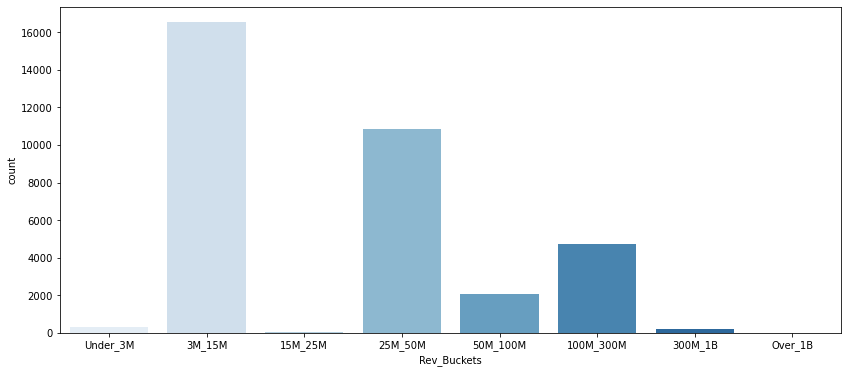

In [250]:
plt.figure(figsize=(14,6))
sns.countplot(x='Rev_Buckets',data=dffff,palette='Blues')

In [251]:
dffff['Rev_Buckets'].value_counts(normalize=True)

3M_15M       0.475206
25M_50M      0.312115
100M_300M    0.136426
50M_100M     0.059656
Under_3M     0.009693
300M_1B      0.006069
15M_25M      0.000805
Over_1B      0.000029
Name: Rev_Buckets, dtype: float64

# Thank You!
____________